<a href="https://colab.research.google.com/github/akbaradie/home-credit-scoring/blob/main/HC_App_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Akbar Adi Nugroho (akbaradie@gmail.com)

Acces my portfolios [HERE](https://akbaradie.github.io/)

## Libraries

In [291]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

## Data Wrangling

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!unzip 'drive/My Drive/Career/Internship/Rakamin Academy/01 Home Credit Indonesia Batch Jan 2024/Week 04/Final Project/home-credit-default-risk.zip' -d 'data/'

Archive:  drive/My Drive/Career/Internship/Rakamin Academy/01 Home Credit Indonesia Batch Jan 2024/Week 04/Final Project/home-credit-default-risk.zip
  inflating: data/HomeCredit_columns_description.csv  
  inflating: data/POS_CASH_balance.csv  
  inflating: data/application_test.csv  
  inflating: data/application_train.csv  
  inflating: data/bureau.csv         
  inflating: data/bureau_balance.csv  
  inflating: data/credit_card_balance.csv  
  inflating: data/installments_payments.csv  
  inflating: data/previous_application.csv  
  inflating: data/sample_submission.csv  


In [12]:
df_train = pd.read_csv('data/application_train.csv')
print('data shape:',df_train.shape)
df_train.head()

data shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,-3648.00,-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,-1134.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,135000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,-4260.00,-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.0

## Exploratory Data Analysis (EDA)

In [13]:
print('Duplicated values: ', df_train.duplicated().sum())
print('Duplicated values in ID: ', df_train['SK_ID_CURR'].duplicated().sum())

Duplicated values:  0
Duplicated values in ID:  0


In [ ]:
df_train.info(verbose=True)

### Univariate Analysis

**Customers Payment Status**

In [15]:
df_train_trgt = df_train.copy()
df_train_trgt['TARGET'] = df_train['TARGET'].apply(lambda x: 'No Pay Difficulties' if x==0 else 'Pay Difficulties')

In [16]:
target_grp = df_train_trgt[['TARGET']].groupby("TARGET").agg(COUNT=("TARGET","count")).sort_values(by=["COUNT"],ascending=False).reset_index()
target_grp['%'] = target_grp['COUNT']/target_grp['COUNT'].sum()*100
target_grp

,TARGET,COUNT,%
0,No Pay Difficulties,282686,91.93
1,Pay Difficulties,24825,8.07


There are about 283K (92%) customer which had no prolbelms in repaying the loan in given time. Meanwhile for about 23K (8%) customers had problemms in repaying the loan.

TARGET is dependent (Y) variable and the dataset is imbalanced.

### Bivariate Analysis

In [17]:
cat = df_train.select_dtypes(include='object').columns
num = df_train.select_dtypes(include='number').columns

cat_in_num = []
for i in num:
  value_type = df_train[i].value_counts().shape[0]
  if value_type<4:
    cat_in_num.append(i)

num = [ x for x in num if x not in cat_in_num]
print('colum contain numeric non-categoric shape:',len(num))
print('colum contain categoric-numeric shape:',len(cat_in_num))
print('colum contain categoric-string shape:',len(cat))

colum contain numeric non-categoric shape: 71
colum contain categoric-numeric shape: 35
colum contain categoric-string shape: 16


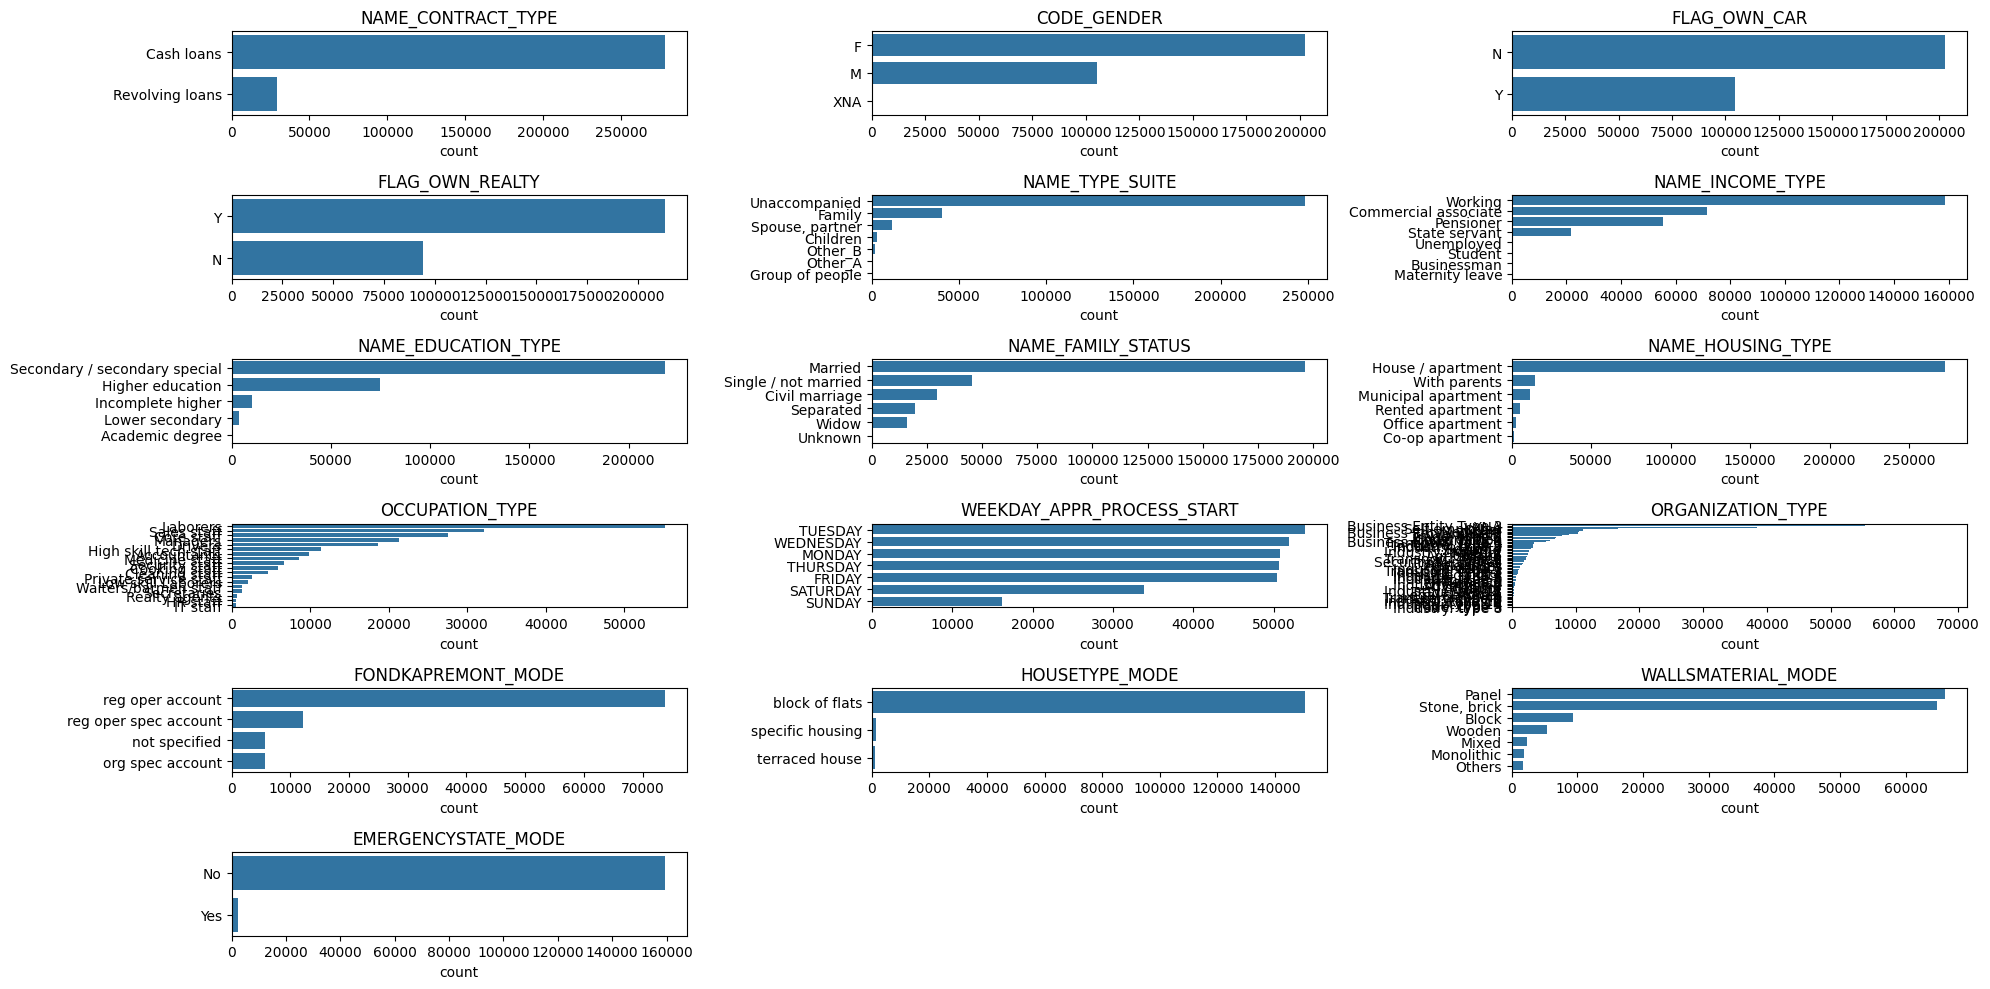

In [18]:
plt.figure(figsize=(20,10))
for i in range(0,len(cat)):
    plt.subplot(6,3,i+1)
    large_to_small = df_train.groupby(cat[i]).size().sort_values().index[::-1]
    sns.countplot(y=df_train[cat[i]], order=large_to_small,orient = 'h').set(ylabel='')
    plt.title(cat[i])
    plt.tight_layout()

There are imbalance data: HOUSETYPE_MODE, EMERGENCYSTATE_MODE

#### EDA in Categorical Columns

**Finding columns contain categorical values in both categorical (string) and numerical**

In [19]:
cat_in_num_twocat = []
for i in range(len(cat_in_num)):
  if df_train[cat_in_num[i]].value_counts().shape[0]==2 and cat_in_num[i] != 'TARGET':
    cat_in_num_twocat.append(cat_in_num[i])

print('There are',len(cat_in_num_twocat),'Categorical-numerical column contain 2 categories:\n',cat_in_num_twocat)

There are 32 Categorical-numerical column contain 2 categories:
 ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


In [20]:
cat_twocat = []
for i in range(len(cat)):
  if df_train[cat[i]].value_counts().shape[0]==2:
    cat_twocat.append(cat[i])

print('There are',len(cat_twocat),'Categorical column contain 2 categories:\n',cat_twocat)

There are 4 Categorical column contain 2 categories:
 ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']


##### 01 **Contract Type VS Target**

In [21]:
ct = df_train_trgt.groupby(by=['TARGET','NAME_CONTRACT_TYPE'], as_index=False)['SK_ID_CURR'].count()
ct['%'] = (ct['SK_ID_CURR']/ct['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
ct.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,NAME_CONTRACT_TYPE,SK_ID_CURR,%
0,No Pay Difficulties,Cash loans,255011,82.93
1,No Pay Difficulties,Revolving loans,27675,9.00
2,Pay Difficulties,Cash loans,23221,7.55
3,Pay Difficulties,Revolving loans,1604,0.52


In [22]:
df_train[['NAME_CONTRACT_TYPE','TARGET']].groupby(['NAME_CONTRACT_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_CONTRACT_TYPE,TARGET
0,Cash loans,0.08
1,Revolving loans,0.05


Around 278K (90,5%) customers made cash loans which is accounted for the majority of total loans in this dataset. Meanwhile around 29K (9,5%) customers made revolving loans.

##### 02 **Gender VS Target**

In [23]:
gt = df_train_trgt.groupby(by=['TARGET','CODE_GENDER'], as_index=False)['SK_ID_CURR'].count()
gt['%'] = (gt['SK_ID_CURR']/gt['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Gender')
gt.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Gender


,TARGET,CODE_GENDER,SK_ID_CURR,%
0,No Pay Difficulties,F,188278,61.23
1,No Pay Difficulties,M,94404,30.70
3,Pay Difficulties,F,14170,4.61
4,Pay Difficulties,M,10655,3.46
2,No Pay Difficulties,XNA,4,0.00


In [24]:
df_train[['CODE_GENDER','TARGET']].groupby(['CODE_GENDER'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,CODE_GENDER,TARGET
1,M,0.10
0,F,0.07
2,XNA,0.00


Majority of clients is Female for about 202K (66%). Meanwhile Male customers is about 105K (34%). However, for about 10% of total men had the problems repaying the loan compared to women clients (about 7%).

##### 03 **Own Car vs Target**

In [25]:
oc = df_train_trgt.groupby(by=['TARGET','FLAG_OWN_CAR'], as_index=False)['SK_ID_CURR'].count()
oc['%'] = (oc['SK_ID_CURR']/oc['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
oc.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,FLAG_OWN_CAR,SK_ID_CURR,%
0,No Pay Difficulties,N,185675,60.38
1,No Pay Difficulties,Y,97011,31.55
2,Pay Difficulties,N,17249,5.61
3,Pay Difficulties,Y,7576,2.46


In [26]:
df_train[['FLAG_OWN_CAR','TARGET']].groupby(['FLAG_OWN_CAR'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_CAR,TARGET
0,N,0.09
1,Y,0.07


Around 201K (66%) clients had no car and 8,5% of them had difficulty on paying loan. Meanwhile, around 7% of clients who had car had difficulty.

##### 04 **Own Realty vs Target**

In [27]:
orealty = df_train_trgt.groupby(by=['TARGET','FLAG_OWN_REALTY'], as_index=False)['SK_ID_CURR'].count()
orealty['%'] = (orealty['SK_ID_CURR']/orealty['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
orealty.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,FLAG_OWN_REALTY,SK_ID_CURR,%
1,No Pay Difficulties,Y,196329,63.84
0,No Pay Difficulties,N,86357,28.08
3,Pay Difficulties,Y,16983,5.52
2,Pay Difficulties,N,7842,2.55


In [28]:
df_train[['FLAG_OWN_REALTY','TARGET']].groupby(['FLAG_OWN_REALTY'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_REALTY,TARGET
0,N,0.08
1,Y,0.08


Around 213K (69%) clients realty, but 8,5% of them had difficulty on paying loan. Meanwhile, around 8% of clients who had no realty had no difficulty.

##### 05 **Emergency State Mode VS Target**

In [29]:
emergency = df_train_trgt.groupby(by=['TARGET','EMERGENCYSTATE_MODE'], as_index=False)['SK_ID_CURR'].count()
emergency['%'] = (emergency['SK_ID_CURR']/emergency['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
emergency.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,EMERGENCYSTATE_MODE,SK_ID_CURR,%
0,No Pay Difficulties,No,148324,91.70
2,Pay Difficulties,No,11104,6.86
1,No Pay Difficulties,Yes,2105,1.30
3,Pay Difficulties,Yes,223,0.14


In [30]:
df_train[['EMERGENCYSTATE_MODE','TARGET']].groupby(['EMERGENCYSTATE_MODE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,EMERGENCYSTATE_MODE,TARGET
1,Yes,0.10
0,No,0.07


Around 2K (1,4%) clients had emergency state and 9,5% of them had difficulty on paying loan. Meanwhile, around 7% of clients who had no emergency state had no difficulty.

##### 06 **Name Type Suite VS Target**

In [31]:
type_suite = df_train_trgt.groupby(by=['TARGET','NAME_TYPE_SUITE'], as_index=False)['SK_ID_CURR'].count()
type_suite['%'] = (type_suite['SK_ID_CURR']/type_suite['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
type_suite.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,NAME_TYPE_SUITE,SK_ID_CURR,%
6,No Pay Difficulties,Unaccompanied,228189,74.52
1,No Pay Difficulties,Family,37140,12.13
13,Pay Difficulties,Unaccompanied,20337,6.64
5,No Pay Difficulties,"Spouse, partner",10475,3.42
0,No Pay Difficulties,Children,3026,0.99
8,Pay Difficulties,Family,3009,0.98
4,No Pay Difficulties,Other_B,1596,0.52
12,Pay Difficulties,"Spouse, partner",895,0.29
3,No Pay Difficulties,Other_A,790,0.26
2,No Pay Difficulties,Group of people,248,0.08


<Axes: xlabel='count', ylabel='NAME_TYPE_SUITE'>

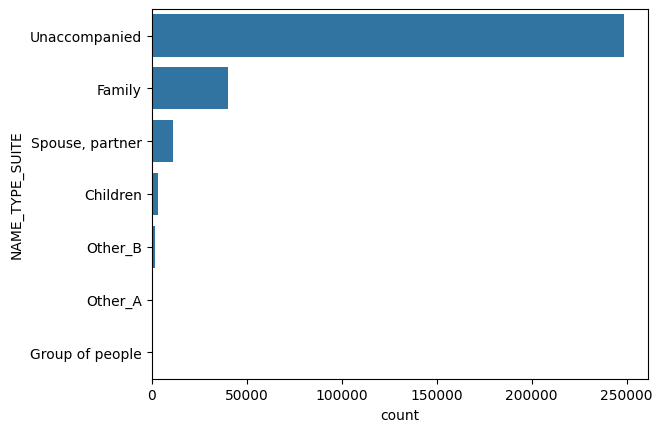

In [32]:
sns.countplot(y='NAME_TYPE_SUITE', data = df_train, order=df_train.groupby('NAME_TYPE_SUITE').size().sort_values(ascending=False).index)

In [33]:
df_train[['NAME_TYPE_SUITE','TARGET']].groupby(['NAME_TYPE_SUITE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_TYPE_SUITE,TARGET
4,Other_B,0.10
3,Other_A,0.09
2,Group of people,0.08
6,Unaccompanied,0.08
5,"Spouse, partner",0.08
1,Family,0.07
0,Children,0.07


Majority of clients was unaccompanied when applied for loans (about 248K or 81% of total) and 8,1% of them had difficulty on paying the loans. Meanwhile, clients who accompanied by Other_A and other_B are less than 1% respectively. But, around 8-10% of them had difficulty on paying the loans.

In [34]:
categories_to_merge = ['Other', 'Trade', 'Industry']

df_train_suite = df_train.copy()

df_train_suite['NAME_TYPE_SUITE'] = df_train_suite['NAME_TYPE_SUITE'].replace({'Other_A':'Other', 'Other_B':'Other'})
df_train_suite.groupby('NAME_TYPE_SUITE').size().reset_index().sort_values(by='NAME_TYPE_SUITE',ascending=False)

,NAME_TYPE_SUITE,0
5,Unaccompanied,248526
4,"Spouse, partner",11370
3,Other,2636
2,Group of people,271
1,Family,40149
0,Children,3267


In [35]:
suite = df_train_suite.groupby(by=['TARGET','NAME_TYPE_SUITE'], as_index=False)['SK_ID_CURR'].count()
suite['%'] = (suite['SK_ID_CURR']/suite['SK_ID_CURR'].sum()*100).round(4)
print('Clients Repayment Abilities By Contract Type')
suite.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,NAME_TYPE_SUITE,SK_ID_CURR,%
5,0,Unaccompanied,228189,74.52
1,0,Family,37140,12.13
11,1,Unaccompanied,20337,6.64
4,0,"Spouse, partner",10475,3.42
0,0,Children,3026,0.99
7,1,Family,3009,0.98
3,0,Other,2386,0.78
10,1,"Spouse, partner",895,0.29
9,1,Other,250,0.08
2,0,Group of people,248,0.08


In [36]:
df_train_suite[['NAME_TYPE_SUITE','TARGET']].groupby(['NAME_TYPE_SUITE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_TYPE_SUITE,TARGET
3,Other,0.09
2,Group of people,0.08
5,Unaccompanied,0.08
4,"Spouse, partner",0.08
1,Family,0.07
0,Children,0.07


##### 07 **Income Type VS Target**

In [37]:
income = df_train_trgt.groupby(by=['NAME_INCOME_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
income['%'] = (income['SK_ID_CURR']/income['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
income.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,NAME_INCOME_TYPE,TARGET,SK_ID_CURR,%
12,Working,No Pay Difficulties,143550,46.68
1,Commercial associate,No Pay Difficulties,66257,21.55
5,Pensioner,No Pay Difficulties,52380,17.03
7,State servant,No Pay Difficulties,20454,6.65
13,Working,Pay Difficulties,15224,4.95
2,Commercial associate,Pay Difficulties,5360,1.74
6,Pensioner,Pay Difficulties,2982,0.97
8,State servant,Pay Difficulties,1249,0.41
9,Student,No Pay Difficulties,18,0.01
10,Unemployed,No Pay Difficulties,14,0.00


In [38]:
df_train[['NAME_INCOME_TYPE','TARGET']].groupby(['NAME_INCOME_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_INCOME_TYPE,TARGET
2,Maternity leave,0.40
6,Unemployed,0.36
7,Working,0.10
1,Commercial associate,0.07
4,State servant,0.06
3,Pensioner,0.05
0,Businessman,0.00
5,Student,0.00


Client who have working as income type have applied for majority of loans, around 158K (51%). But, around 10% of them have difficulty in paying loans. Client who have Businessman and Studnet as income type are almost 0% of total clients, but they have no difficulty in paying loans.

The highest proportion of type that have difficulty in paying loans are Maternity leave and Unemployed which is 40% and 36% respectively. But, there is only 5 and 22 client with maternity leave and unemployed respectively.

##### 08 **Education Type VS Target**

In [39]:
edu_type = df_train_trgt.groupby(by=['TARGET','NAME_EDUCATION_TYPE'], as_index=False)['SK_ID_CURR'].count()
edu_type['%'] = (edu_type['SK_ID_CURR']/edu_type['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
edu_type.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,NAME_EDUCATION_TYPE,SK_ID_CURR,%
4,No Pay Difficulties,Secondary / secondary special,198867,64.67
1,No Pay Difficulties,Higher education,70854,23.04
9,Pay Difficulties,Secondary / secondary special,19524,6.35
2,No Pay Difficulties,Incomplete higher,9405,3.06
6,Pay Difficulties,Higher education,4009,1.30
3,No Pay Difficulties,Lower secondary,3399,1.11
7,Pay Difficulties,Incomplete higher,872,0.28
8,Pay Difficulties,Lower secondary,417,0.14
0,No Pay Difficulties,Academic degree,161,0.05
5,Pay Difficulties,Academic degree,3,0.00


In [40]:
df_train[['NAME_EDUCATION_TYPE','TARGET']].groupby(['NAME_EDUCATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_EDUCATION_TYPE,TARGET
3,Lower secondary,0.11
4,Secondary / secondary special,0.09
2,Incomplete higher,0.08
1,Higher education,0.05
0,Academic degree,0.02


Most of the clients' education type are Secondary and higher education which is around 218K (71%) and 75K (24%) respectively. But 9% of clients with lower secondary as education type have difficulty in paying loans. Meanwhile, client's education type with the highest rate of having difficulty in paying loans is lower secondary (11%)

##### 09 **Family Status VS Target**

In [41]:
family_stat = df_train_trgt.groupby(by=['TARGET','NAME_FAMILY_STATUS'], as_index=False)['SK_ID_CURR'].count()
family_stat['%'] = (family_stat['SK_ID_CURR']/family_stat['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
family_stat.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,NAME_FAMILY_STATUS,SK_ID_CURR,%
1,No Pay Difficulties,Married,181582,59.05
3,No Pay Difficulties,Single / not married,40987,13.33
0,No Pay Difficulties,Civil marriage,26814,8.72
2,No Pay Difficulties,Separated,18150,5.90
5,No Pay Difficulties,Widow,15151,4.93
7,Pay Difficulties,Married,14850,4.83
9,Pay Difficulties,Single / not married,4457,1.45
6,Pay Difficulties,Civil marriage,2961,0.96
8,Pay Difficulties,Separated,1620,0.53
10,Pay Difficulties,Widow,937,0.30


In [42]:
df_train[['NAME_FAMILY_STATUS','TARGET']].groupby(['NAME_FAMILY_STATUS'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_FAMILY_STATUS,TARGET
0,Civil marriage,0.10
3,Single / not married,0.10
2,Separated,0.08
1,Married,0.08
5,Widow,0.06
4,Unknown,0.00


Most clients have married and followed by single which is around 196K (64%) and 45K (14%). Around 10% of Civil marriage and single clients have difficulty in paying loans.

##### 10 **Housing Type VS Target**

In [43]:
house_type = df_train_trgt.groupby(by=['TARGET','NAME_HOUSING_TYPE'], as_index=False)['SK_ID_CURR'].count()
house_type['%'] = (house_type['SK_ID_CURR']/house_type['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
house_type.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,NAME_HOUSING_TYPE,SK_ID_CURR,%
1,No Pay Difficulties,House / apartment,251596,81.82
7,Pay Difficulties,House / apartment,21272,6.92
5,No Pay Difficulties,With parents,13104,4.26
2,No Pay Difficulties,Municipal apartment,10228,3.33
4,No Pay Difficulties,Rented apartment,4280,1.39
3,No Pay Difficulties,Office apartment,2445,0.80
11,Pay Difficulties,With parents,1736,0.56
0,No Pay Difficulties,Co-op apartment,1033,0.34
8,Pay Difficulties,Municipal apartment,955,0.31
10,Pay Difficulties,Rented apartment,601,0.20


In [44]:
df_train[['NAME_HOUSING_TYPE','TARGET']].groupby(['NAME_HOUSING_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_HOUSING_TYPE,TARGET
4,Rented apartment,0.12
5,With parents,0.12
2,Municipal apartment,0.09
0,Co-op apartment,0.08
1,House / apartment,0.08
3,Office apartment,0.07


Most of clients have house, around 273K (88%). Clients who living in rented apartment and with parents were only around 5K (1,5%) and 15K (5%) respectively. But, 12% and 11% of them are having difficulty in paying loans.

##### 11 **Occupation Type VS Target**

<Axes: xlabel='count', ylabel='OCCUPATION_TYPE'>

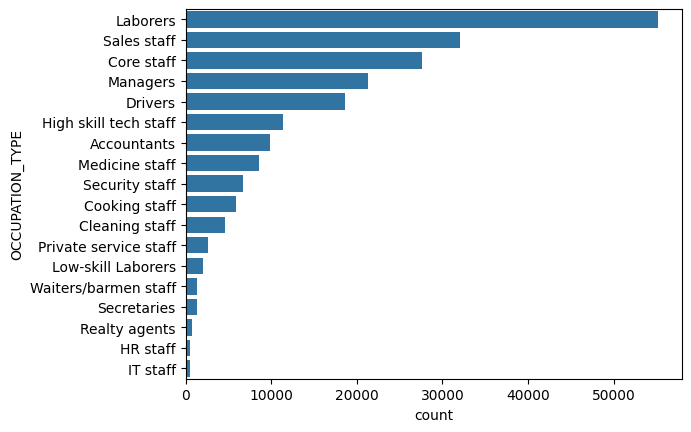

In [45]:
sns.countplot(y='OCCUPATION_TYPE', data = df_train, order=df_train.groupby('OCCUPATION_TYPE').size().sort_values(ascending=False).index)

In [46]:
occup_type = df_train_trgt.groupby(by=['TARGET','OCCUPATION_TYPE'], as_index=False)['SK_ID_CURR'].count()
occup_type['%'] = (occup_type['SK_ID_CURR']/occup_type['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
occup_type.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,OCCUPATION_TYPE,SK_ID_CURR,%
8,No Pay Difficulties,Laborers,49348,23.37
14,No Pay Difficulties,Sales staff,29010,13.74
3,No Pay Difficulties,Core staff,25832,12.24
10,No Pay Difficulties,Managers,20043,9.49
4,No Pay Difficulties,Drivers,16496,7.81
6,No Pay Difficulties,High skill tech staff,10679,5.06
0,No Pay Difficulties,Accountants,9339,4.42
11,No Pay Difficulties,Medicine staff,7965,3.77
16,No Pay Difficulties,Security staff,5999,2.84
26,Pay Difficulties,Laborers,5838,2.77


In [47]:
df_train[['OCCUPATION_TYPE','TARGET']].groupby(['OCCUPATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,OCCUPATION_TYPE,TARGET
9,Low-skill Laborers,0.17
4,Drivers,0.11
17,Waiters/barmen staff,0.11
16,Security staff,0.11
8,Laborers,0.11
2,Cooking staff,0.10
14,Sales staff,0.10
1,Cleaning staff,0.10
13,Realty agents,0.08
15,Secretaries,0.07


##### 12 **Weekday App VS Target**

In [48]:
weekday_app = df_train_trgt.groupby(by=['TARGET','WEEKDAY_APPR_PROCESS_START'], as_index=False)['SK_ID_CURR'].count()
weekday_app['%'] = (weekday_app['SK_ID_CURR']/weekday_app['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
weekday_app.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,WEEKDAY_APPR_PROCESS_START,SK_ID_CURR,%
5,No Pay Difficulties,TUESDAY,49400,16.06
6,No Pay Difficulties,WEDNESDAY,47696,15.51
1,No Pay Difficulties,MONDAY,46780,15.21
4,No Pay Difficulties,THURSDAY,46493,15.12
0,No Pay Difficulties,FRIDAY,46237,15.04
2,No Pay Difficulties,SATURDAY,31182,10.14
3,No Pay Difficulties,SUNDAY,14898,4.84
12,Pay Difficulties,TUESDAY,4501,1.46
13,Pay Difficulties,WEDNESDAY,4238,1.38
7,Pay Difficulties,FRIDAY,4101,1.33


In [49]:
df_train[['WEEKDAY_APPR_PROCESS_START','TARGET']].groupby(['WEEKDAY_APPR_PROCESS_START'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,WEEKDAY_APPR_PROCESS_START,TARGET
5,TUESDAY,0.08
6,WEDNESDAY,0.08
0,FRIDAY,0.08
4,THURSDAY,0.08
3,SUNDAY,0.08
2,SATURDAY,0.08
1,MONDAY,0.08


##### 13 **Organization Type VS Target**

In [393]:
org_type = df_train_trgt.groupby(by=['TARGET','ORGANIZATION_TYPE'], as_index=False)['SK_ID_CURR'].count()
org_type['%'] = (org_type['SK_ID_CURR']/org_type['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
org_type.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,ORGANIZATION_TYPE,SK_ID_CURR,%
57,No Pay Difficulties,XNA,52384,17.030
115,Pay Difficulties,XNA,2990,0.970


<Axes: xlabel='count', ylabel='ORGANIZATION_TYPE'>

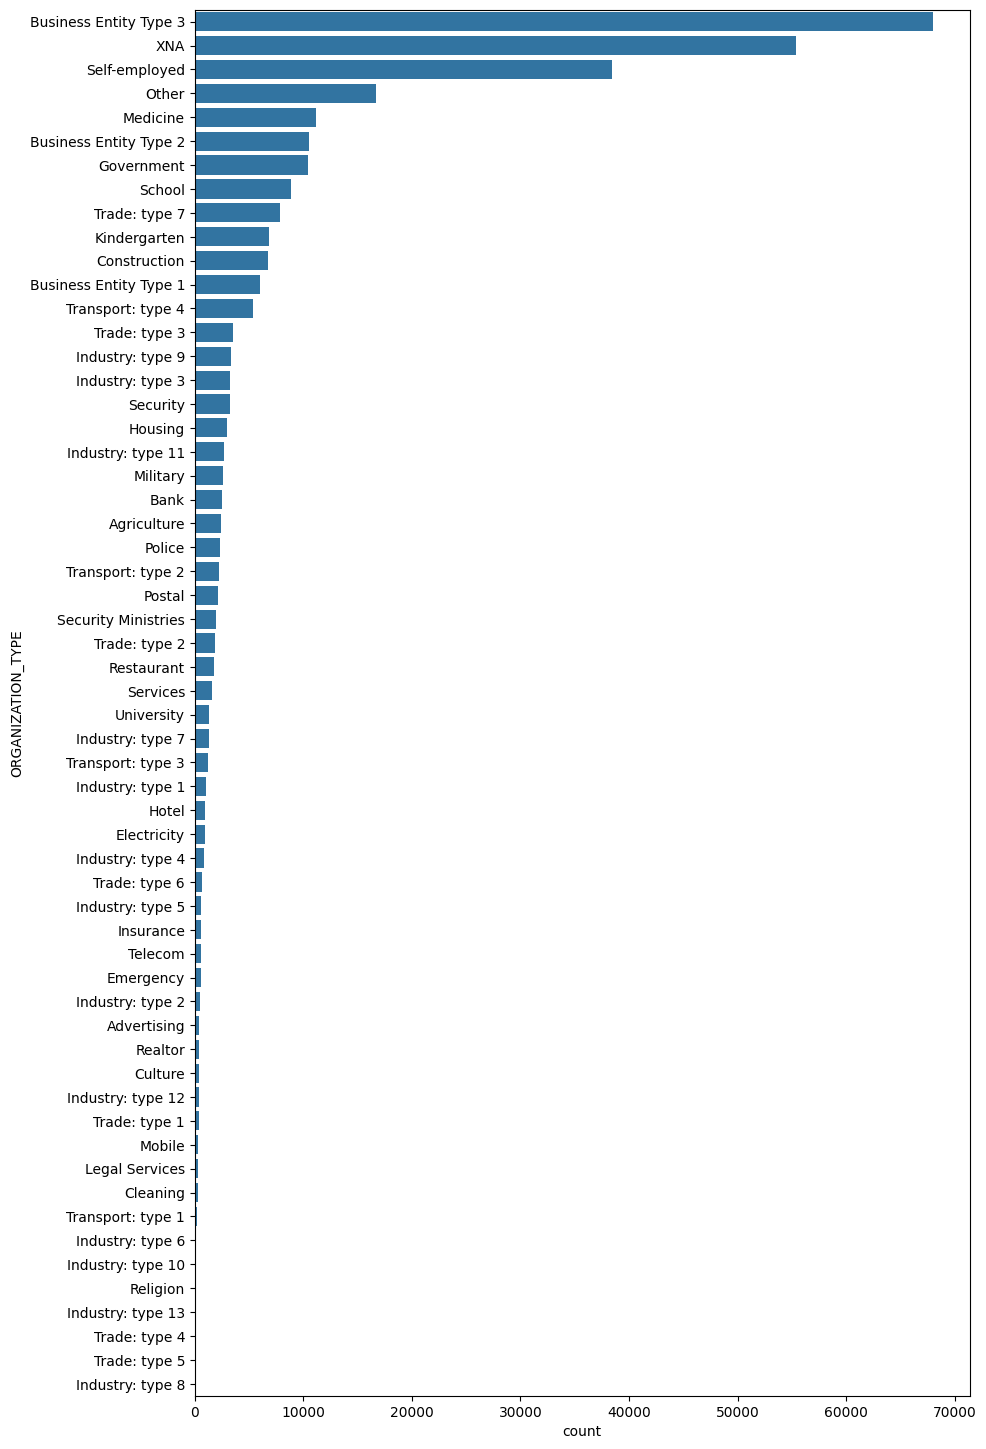

In [51]:
plt.figure(figsize=(10, 18))
sns.countplot(y='ORGANIZATION_TYPE', data = df_train, order=df_train.groupby('ORGANIZATION_TYPE').size().sort_values(ascending=False).index)

In [193]:
df_train.groupby('ORGANIZATION_TYPE').size().reset_index().sort_values(by='ORGANIZATION_TYPE',ascending=False)

,ORGANIZATION_TYPE,0
36,XNA,55374
35,University,1327
34,Transport,8990
33,Trade,14315
32,Telecom,577
31,Services,1575
30,Self-employed,38412
29,Security Ministries,1974
28,Security,3247
27,School,8893


In [192]:
df_train[['ORGANIZATION_TYPE','TARGET']].groupby(['ORGANIZATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,ORGANIZATION_TYPE,TARGET
26,Restaurant,0.12
7,Construction,0.12
6,Cleaning,0.11
24,Realtor,0.11
1,Agriculture,0.10
30,Self-employed,0.10
28,Security,0.10
34,Transport,0.10
5,Business Entity Type 3,0.09
20,Mobile,0.09


**Merge Some Organization Type**

In [54]:
df_train_org = df_train.copy()

In [55]:
categories_to_merge = ['Transport', 'Trade', 'Industry']

def replace_categories(value):
    if 'transport' in value.lower():
        return 'Transport'
    elif 'trade' in value.lower():
        return 'Trade'
    elif 'industry' in value.lower():
        return 'Industry'
    return value

# Replace values in the DataFrame
df_train_org['ORGANIZATION_TYPE'] = df_train_org['ORGANIZATION_TYPE'].apply(replace_categories)
df_train_org.groupby('ORGANIZATION_TYPE').size().reset_index().sort_values(by='ORGANIZATION_TYPE',ascending=False)

,ORGANIZATION_TYPE,0
36,XNA,55374
35,University,1327
34,Transport,8990
33,Trade,14315
32,Telecom,577
31,Services,1575
30,Self-employed,38412
29,Security Ministries,1974
28,Security,3247
27,School,8893


<Axes: xlabel='count', ylabel='ORGANIZATION_TYPE'>

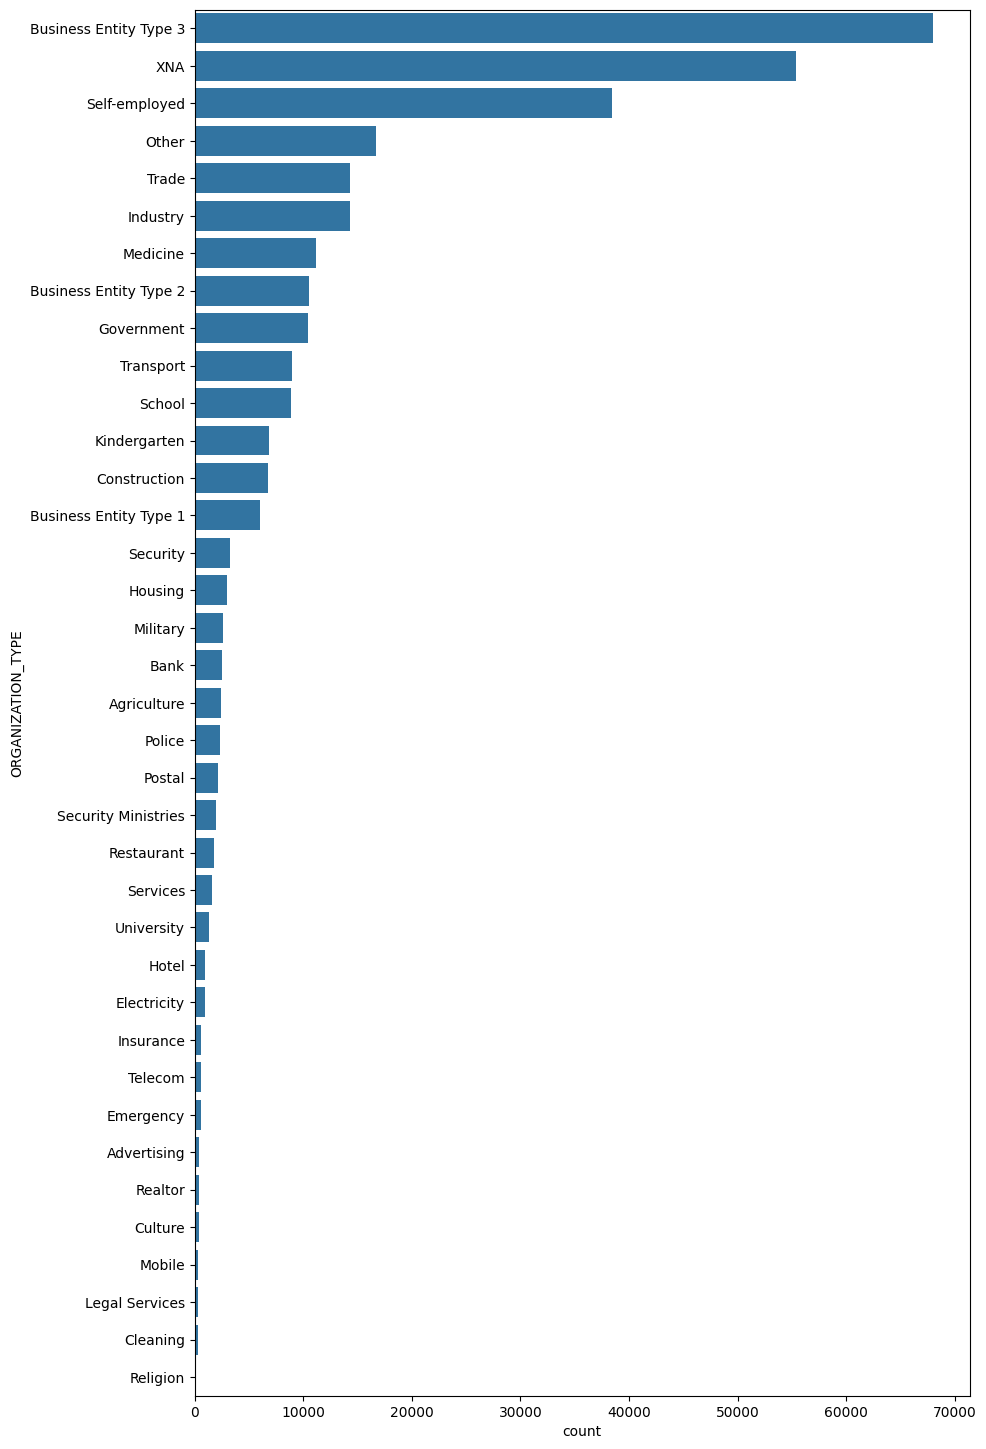

In [56]:
plt.figure(figsize=(10, 18))
sns.countplot(y='ORGANIZATION_TYPE', data = df_train_org, order=df_train_org.groupby('ORGANIZATION_TYPE').size().sort_values(ascending=False).index)

##### 14 **Fondkapremont Mode VS Target**

In [57]:
fond_mode = df_train_trgt.groupby(by=['TARGET','FONDKAPREMONT_MODE'], as_index=False)['SK_ID_CURR'].count()
fond_mode['%'] = (fond_mode['SK_ID_CURR']/fond_mode['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
fond_mode.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,FONDKAPREMONT_MODE,SK_ID_CURR,%
2,No Pay Difficulties,reg oper account,68678,70.64
3,No Pay Difficulties,reg oper spec account,11288,11.61
1,No Pay Difficulties,org spec account,5292,5.44
0,No Pay Difficulties,not specified,5258,5.41
6,Pay Difficulties,reg oper account,5152,5.30
7,Pay Difficulties,reg oper spec account,792,0.81
4,Pay Difficulties,not specified,429,0.44
5,Pay Difficulties,org spec account,327,0.34


In [58]:
df_train[['FONDKAPREMONT_MODE','TARGET']].groupby(['FONDKAPREMONT_MODE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FONDKAPREMONT_MODE,TARGET
0,not specified,0.08
2,reg oper account,0.07
3,reg oper spec account,0.07
1,org spec account,0.06


##### 15 **Housetype VS Target**

In [59]:
house_type = df_train_trgt.groupby(by=['TARGET','HOUSETYPE_MODE'], as_index=False)['SK_ID_CURR'].count()
house_type['%'] = (house_type['SK_ID_CURR']/house_type['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
house_type.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,HOUSETYPE_MODE,SK_ID_CURR,%
0,No Pay Difficulties,block of flats,140053,91.41
3,Pay Difficulties,block of flats,10450,6.82
1,No Pay Difficulties,specific housing,1347,0.88
2,No Pay Difficulties,terraced house,1109,0.72
4,Pay Difficulties,specific housing,152,0.10
5,Pay Difficulties,terraced house,103,0.07


In [60]:
df_train[['HOUSETYPE_MODE','TARGET']].groupby(['HOUSETYPE_MODE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,HOUSETYPE_MODE,TARGET
1,specific housing,0.10
2,terraced house,0.08
0,block of flats,0.07


##### 16 **Wallsmaterial Mode VS Target**

In [61]:
walls_mat = df_train_trgt.groupby(by=['TARGET','WALLSMATERIAL_MODE'], as_index=False)['SK_ID_CURR'].count()
walls_mat['%'] = (walls_mat['SK_ID_CURR']/walls_mat['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
walls_mat.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,WALLSMATERIAL_MODE,SK_ID_CURR,%
4,No Pay Difficulties,Panel,61848,40.91
5,No Pay Difficulties,"Stone, brick",60015,39.70
0,No Pay Difficulties,Block,8603,5.69
6,No Pay Difficulties,Wooden,4842,3.20
12,Pay Difficulties,"Stone, brick",4800,3.18
11,Pay Difficulties,Panel,4192,2.77
1,No Pay Difficulties,Mixed,2123,1.40
2,No Pay Difficulties,Monolithic,1695,1.12
3,No Pay Difficulties,Others,1490,0.99
7,Pay Difficulties,Block,650,0.43


In [62]:
df_train[['WALLSMATERIAL_MODE','TARGET']].groupby(['WALLSMATERIAL_MODE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,WALLSMATERIAL_MODE,TARGET
6,Wooden,0.10
3,Others,0.08
1,Mixed,0.08
5,"Stone, brick",0.07
0,Block,0.07
4,Panel,0.06
2,Monolithic,0.05


### EDA in Numerical Columns

In [63]:
num = df_train.select_dtypes(include='number').columns

cat_in_num = []
for i in num:
  value_type = df_train[i].value_counts().shape[0]
  if value_type<4:
    cat_in_num.append(i)

num = [x for x in num if x not in cat_in_num]

print('There are',len(num),'columns having numerical values')
print('There are',len(cat_in_num),'columns with less than 10 categories')

There are 71 columns having numerical values
There are 35 columns with less than 10 categories


In [64]:
# plt.figure(figsize=(28,30))
# for i in range(1,len(num)):
#     plt.subplot(10,7,i)
#     sns.kdeplot(x=df_train[num[i]], palette='rocket')
#     plt.title(num[i])
#     plt.xlabel(' ')
#     plt.tight_layout()

There are some anomaly: DAYS_EMPLOYED, CNT_FAM_MEMBERS, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR

In [65]:
outlier_num = ['AMT_REQ_CREDIT_BUREAU_QRT',
               'DEF_30_CNT_SOCIAL_CIRCLE','OBS_30_CNT_SOCIAL_CIRCLE',
               'DEF_60_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE']

outlier_check_df = pd.DataFrame()
for i in outlier_num:
  outlier_check_df[i]=df_train[i].dropna().sort_values().tail(5).values

outlier_check_df

,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE
0,8.00,6.00,29.00,6.00,29.00
1,8.00,6.00,30.00,6.00,29.00
2,8.00,7.00,30.00,6.00,30.00
3,19.00,8.00,47.00,7.00,47.00
4,261.00,34.00,348.00,24.00,344.00


In [66]:
for col in df_train[outlier_num]:
  median_val = df_train[col].median()
  max_idx = df_train[col].nlargest(2).index
  for j in max_idx:
    df_train.at[j,col] = median_val

In [67]:
for i in outlier_num:
  outlier_check_df[i]=df_train[i].dropna().sort_values().tail(5).values

outlier_check_df

,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE
0,8.00,6.00,27.00,5.00,27.00
1,8.00,6.00,28.00,5.00,28.00
2,8.00,6.00,29.00,6.00,29.00
3,8.00,6.00,30.00,6.00,29.00
4,8.00,7.00,30.00,6.00,30.00


In [68]:
# plt.figure(figsize=(20,16))
# for i in range(0,len(cat_in_num)):
#     plt.subplot(7,5,i+1)
#     large_to_small = df_train.groupby(cat_in_num[i]).size().sort_values().index[::-1]
#     sns.countplot(y=df_train[cat_in_num[i]], order=large_to_small, orient = 'h').set(ylabel='')
#     plt.title(cat_in_num[i])
#     plt.tight_layout()

There are imbalance data: FLAG_MOBIL,FLAG_CONT_MOBILE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_4,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21

In [69]:
unused_cat_in_num = ['FLAG_MOBIL','FLAG_CONT_MOBILE','FLAG_EMAIL',
                     'FLAG_DOCUMENT_2','REG_REGION_NOT_LIVE_REGION',
                     'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
                     'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_4','FLAG_DOCUMENT_5',
                     'FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9',
                      'FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12',
                      'FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15',
                      'FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18',
                      'FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']

unused_cat_in_num_check_df = pd.DataFrame()
for i in unused_cat_in_num:
  unused_cat_in_num_check_df[i]=np.append(np.array(df_train[i].value_counts()/df_train[i].value_counts().sum()*100),df_train[i].isna().sum())
  unused_cat_in_num_check_df[i]=unused_cat_in_num_check_df[i].round(2)

unused_cat_in_num_check_df

,FLAG_MOBIL,FLAG_CONT_MOBILE,FLAG_EMAIL,FLAG_DOCUMENT_2,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100.00,99.81,94.33,100.00,98.49,94.92,95.93,92.18,99.99,98.49,91.19,99.98,91.86,99.61,100.00,99.61,100.00,99.65,99.71,99.88,99.01,99.97,99.19,99.94,99.95,99.97
1,0.00,0.19,5.67,0.00,1.51,5.08,4.07,7.82,0.01,1.51,8.81,0.02,8.14,0.39,0.00,0.39,0.00,0.35,0.29,0.12,0.99,0.03,0.81,0.06,0.05,0.03
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Correlation

In [70]:
# Find correlations with the target and sort
correlations = df_train.corr()['TARGET'].sort_values(ascending=False).reset_index()

# Display correlations
print('Most Positive Correlations:\n', correlations.head(15))
print('\nMost Negative Correlations:\n', correlations.tail(10))

Most Positive Correlations:
                           index  TARGET
0                        TARGET    1.00
1                    DAYS_BIRTH    0.08
2   REGION_RATING_CLIENT_W_CITY    0.06
3          REGION_RATING_CLIENT    0.06
4        DAYS_LAST_PHONE_CHANGE    0.06
5               DAYS_ID_PUBLISH    0.05
6        REG_CITY_NOT_WORK_CITY    0.05
7                FLAG_EMP_PHONE    0.05
8        REG_CITY_NOT_LIVE_CITY    0.04
9               FLAG_DOCUMENT_3    0.04
10            DAYS_REGISTRATION    0.04
11                  OWN_CAR_AGE    0.04
12     DEF_30_CNT_SOCIAL_CIRCLE    0.03
13      LIVE_CITY_NOT_WORK_CITY    0.03
14     DEF_60_CNT_SOCIAL_CIRCLE    0.03

Most Negative Correlations:
                           index  TARGET
96                ELEVATORS_AVG   -0.03
97   REGION_POPULATION_RELATIVE   -0.04
98              AMT_GOODS_PRICE   -0.04
99               FLOORSMAX_MODE   -0.04
100              FLOORSMAX_MEDI   -0.04
101               FLOORSMAX_AVG   -0.04
102               DAY

## Data Cleaning

In [394]:
df_train_v1 = df_train.drop('SK_ID_CURR',axis=1)
df_train_v1.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,351000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,-3648.000,-2120,NaN,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,0.069,0.083,0.125,0.037,0.020,0.019,0.000,0.000,0.025,0.038,0.972,0.634,0.014,0.000,0.069,0.083,0.125,0.038,0.022,0.020,0.000,0.000,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,-1134.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,1129500.000,Family,State servant,Higher education,Married,House / apartment,0.004,-16765,-1188,-1186.000,-291,NaN,1,1,0,1,1,0,Core staff,2.000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311,0.622,NaN,0.096,0.053,0.985,0.796,0.060,0.080,0.035,0.292,0.333,0.013,0.077,0.055,0.004,0.010,0.092,0.054,0.985,0.804,0.050,0.081,0.035,0.292,0.333,0.013,0.079,0.055,0.000,0.000,0.097,0.053,0.985,0.799,0.061,0.080,0.035,0.292,0.333,0.013,0.079,0.056,0.004,0.010,reg oper account,block of flats,0.071,Block,No,1.000,0.000,1.000,0.000,-828.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,135000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010,-19046,-225,-4260.000,-2531,26.000,1,1,1,1,1,0,Laborers,1.000,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.556,0.730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### Checking Missing and Negative Values

In [395]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        mis_val_table = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        mis_val_table = mis_val_table[mis_val_table.iloc[:,0]!=0]

        mis_val_table = mis_val_table.sort_values('% of Total Values', ascending=False).round(1)

        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table.shape[0]) +
              " columns that have missing values.")

        return mis_val_table

missing_values = missing_values_table(df_train_v1).reset_index()
missing_values

Your selected dataframe has 121 columns.
There are 68 columns that have missing values.


,index,Missing Values,% of Total Values
0,COMMONAREA_MODE,214865,69.900
1,COMMONAREA_AVG,214865,69.900
2,COMMONAREA_MEDI,214865,69.900
3,NONLIVINGAPARTMENTS_MEDI,213514,69.400
4,NONLIVINGAPARTMENTS_MODE,213514,69.400
...,...,...,...
63,AMT_GOODS_PRICE,278,0.100
64,AMT_ANNUITY,12,0.000
65,CNT_FAM_MEMBERS,4,0.000
66,NAME_FAMILY_STATUS,2,0.000


In [396]:
miss_val_ge50 = missing_values[missing_values['% of Total Values']>=45]['index'].values
print(miss_val_ge50)
print('Columns with null >50%:',miss_val_ge50.shape)

['COMMONAREA_MODE' 'COMMONAREA_AVG' 'COMMONAREA_MEDI'
 'NONLIVINGAPARTMENTS_MEDI' 'NONLIVINGAPARTMENTS_MODE'
 'NONLIVINGAPARTMENTS_AVG' 'FONDKAPREMONT_MODE' 'LIVINGAPARTMENTS_MEDI'
 'LIVINGAPARTMENTS_AVG' 'LIVINGAPARTMENTS_MODE' 'FLOORSMIN_AVG'
 'FLOORSMIN_MODE' 'FLOORSMIN_MEDI' 'YEARS_BUILD_MODE' 'YEARS_BUILD_MEDI'
 'YEARS_BUILD_AVG' 'OWN_CAR_AGE' 'LANDAREA_AVG' 'LANDAREA_MODE'
 'LANDAREA_MEDI' 'BASEMENTAREA_AVG' 'BASEMENTAREA_MEDI'
 'BASEMENTAREA_MODE' 'EXT_SOURCE_1' 'NONLIVINGAREA_MEDI'
 'NONLIVINGAREA_AVG' 'NONLIVINGAREA_MODE' 'ELEVATORS_MEDI' 'ELEVATORS_AVG'
 'ELEVATORS_MODE' 'WALLSMATERIAL_MODE' 'APARTMENTS_AVG' 'APARTMENTS_MEDI'
 'APARTMENTS_MODE' 'ENTRANCES_MODE' 'ENTRANCES_AVG' 'ENTRANCES_MEDI'
 'LIVINGAREA_MEDI' 'LIVINGAREA_MODE' 'LIVINGAREA_AVG' 'HOUSETYPE_MODE'
 'FLOORSMAX_AVG' 'FLOORSMAX_MEDI' 'FLOORSMAX_MODE'
 'YEARS_BEGINEXPLUATATION_MEDI' 'YEARS_BEGINEXPLUATATION_MODE'
 'YEARS_BEGINEXPLUATATION_AVG' 'TOTALAREA_MODE' 'EMERGENCYSTATE_MODE']
Columns with null >50%: (49,)


In [397]:
df_train_v1=df_train_v1.drop(miss_val_ge50,axis=1)
print(df_train_v1.shape)
missing_values_table(df_train_v1).reset_index()

(307511, 72)
Your selected dataframe has 72 columns.
There are 19 columns that have missing values.


,index,Missing Values,% of Total Values
0,OCCUPATION_TYPE,96391,31.300
1,EXT_SOURCE_3,60965,19.800
2,AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.500
3,AMT_REQ_CREDIT_BUREAU_QRT,41519,13.500
4,AMT_REQ_CREDIT_BUREAU_MON,41519,13.500
5,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.500
6,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.500
7,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.500
8,NAME_TYPE_SUITE,1292,0.400
9,DEF_60_CNT_SOCIAL_CIRCLE,1021,0.300


#### Columns contain negative value

In [398]:
num_col_neg = df_train_v1.select_dtypes(include='number')
num_col_neg = num_col_neg.columns[num_col_neg.lt(0).any()]
num_col_neg

Index(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')

In [399]:
df_train_v1[num_col_neg] = (df_train_v1[num_col_neg].abs()/365).round(2)
df_train_v1[num_col_neg].head()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
0,25.920,1.750,9.990,5.810,3.110
1,45.930,3.250,3.250,0.800,2.270
2,52.180,0.620,11.670,6.930,2.230
3,52.070,8.330,26.940,6.680,1.690
4,54.610,8.320,11.810,9.470,3.030


#### Numeric and Categoric columns contain null value

In [400]:
num_col_null = df_train_v1.select_dtypes(include='number')
num_col_null = num_col_null.columns[num_col_null.isnull().any()]
num_col_null

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [401]:
missing_values_table(df_train_v1[num_col_null]).reset_index()

Your selected dataframe has 16 columns.
There are 16 columns that have missing values.


,index,Missing Values,% of Total Values
0,EXT_SOURCE_3,60965,19.800
1,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.500
2,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.500
3,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.500
4,AMT_REQ_CREDIT_BUREAU_MON,41519,13.500
5,AMT_REQ_CREDIT_BUREAU_QRT,41519,13.500
6,AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.500
7,OBS_30_CNT_SOCIAL_CIRCLE,1021,0.300
8,DEF_30_CNT_SOCIAL_CIRCLE,1021,0.300
9,OBS_60_CNT_SOCIAL_CIRCLE,1021,0.300


In [402]:
cat_col_null = df_train_v1.select_dtypes(include='object')
cat_col_null = cat_col_null.columns[cat_col_null.isnull().any()]
cat_col_null

Index(['NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE'], dtype='object')

### Invalid Data and Outliers

In [403]:
cat = df_train_v1.select_dtypes(include='object').columns
num = df_train_v1.select_dtypes(include='number').columns

cat_in_num = []
for i in num:
  value_type = df_train_v1[i].value_counts().shape[0]
  if value_type<4:
    cat_in_num.append(i)

num = [ x for x in num if x not in cat_in_num]
print('colum contain numeric non-categoric shape:',len(num))
print('colum contain categoric-numeric shape:',len(cat_in_num))
print('colum contain categoric-string shape:',len(cat))

colum contain numeric non-categoric shape: 25
colum contain categoric-numeric shape: 35
colum contain categoric-string shape: 12


#### Viz Categorical in Numeric Data

In [404]:
print(cat_in_num)

['TARGET', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


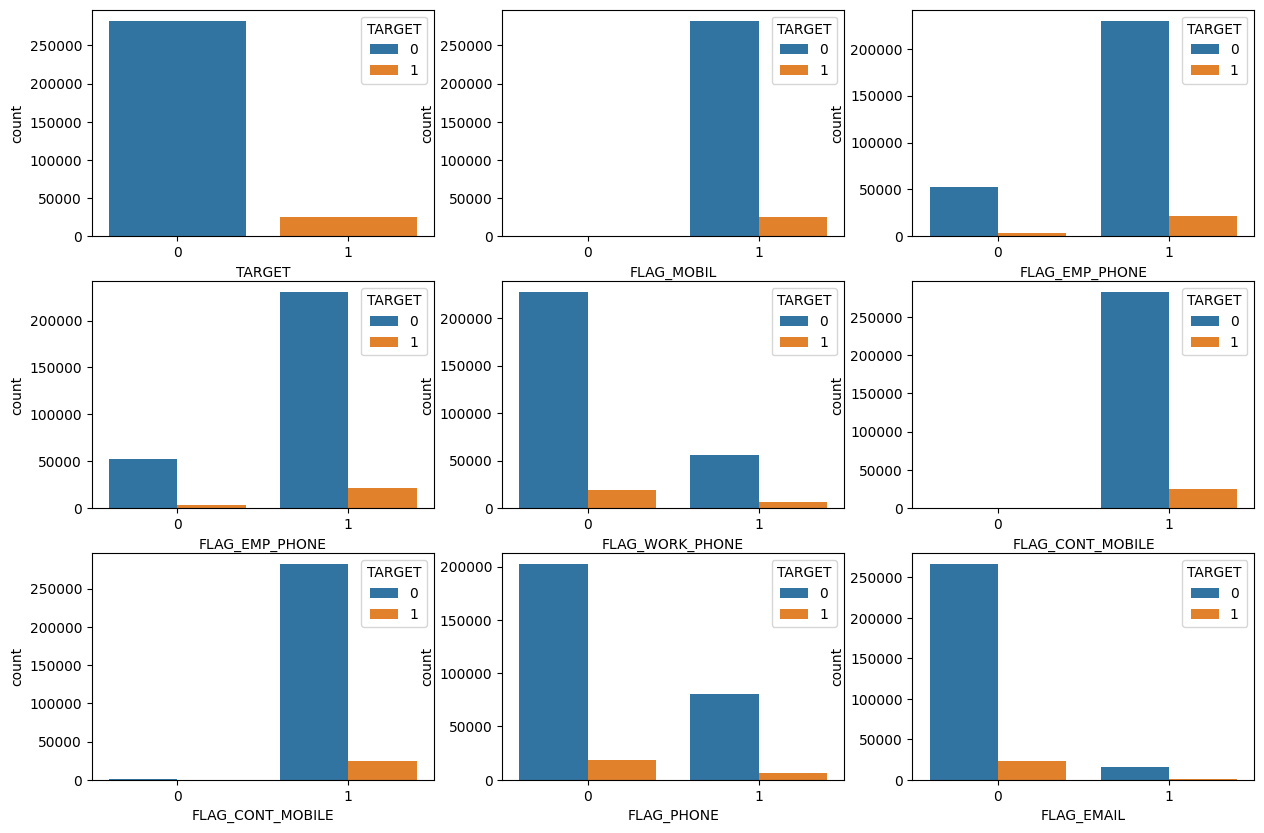

In [405]:
#Outlier in categoric-numeric #1
fig, ax = plt.subplots(3,3, figsize=(15,10))

for i in range(3):
  for j in range(3):
    sns.countplot(x=cat_in_num[2*i+j], data = df_train, hue = 'TARGET', ax=ax[i][j])

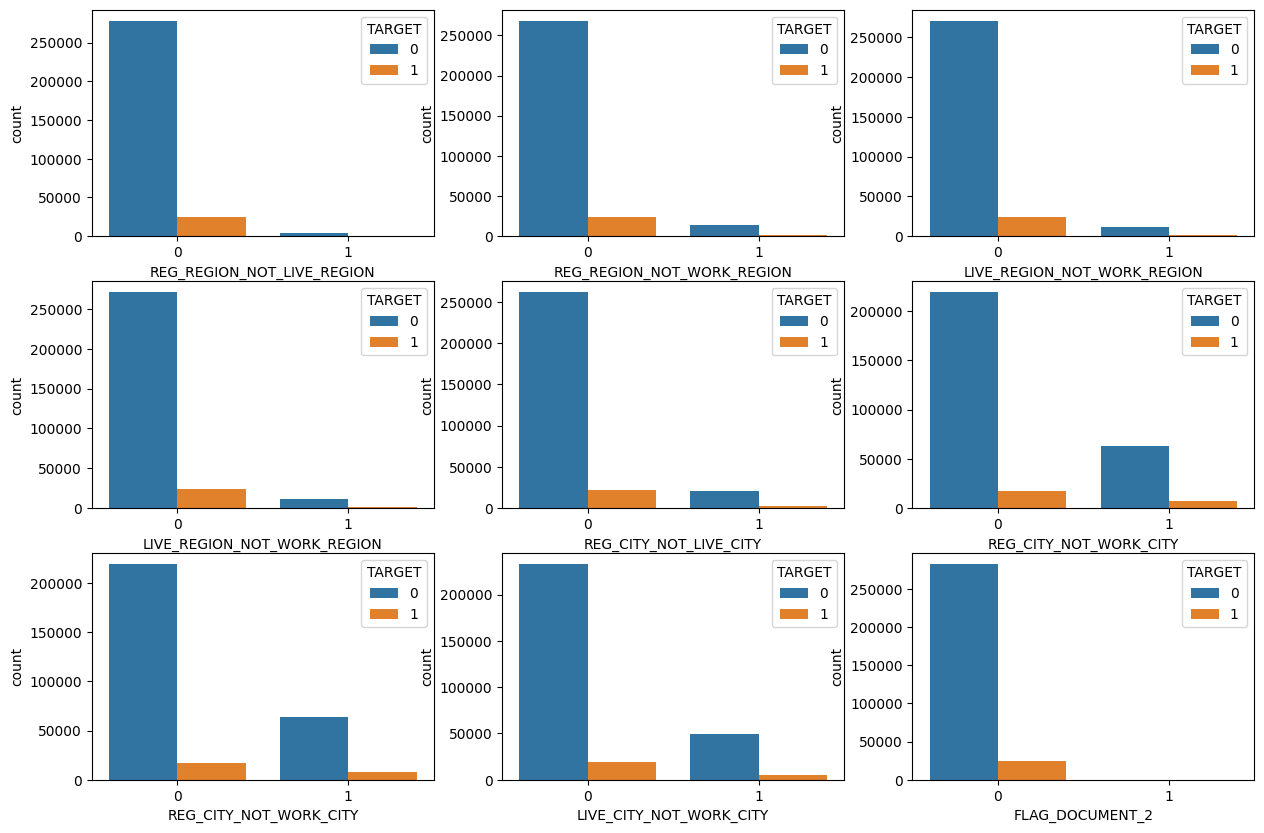

In [406]:
#Outlier in categoric-numeric #2
fig, ax = plt.subplots(3,3, figsize=(15,10))

for i in range(3):
  for j in range(3):
    sns.countplot(x=cat_in_num[2*i+j+9], data = df_train, hue = 'TARGET', ax=ax[i][j])

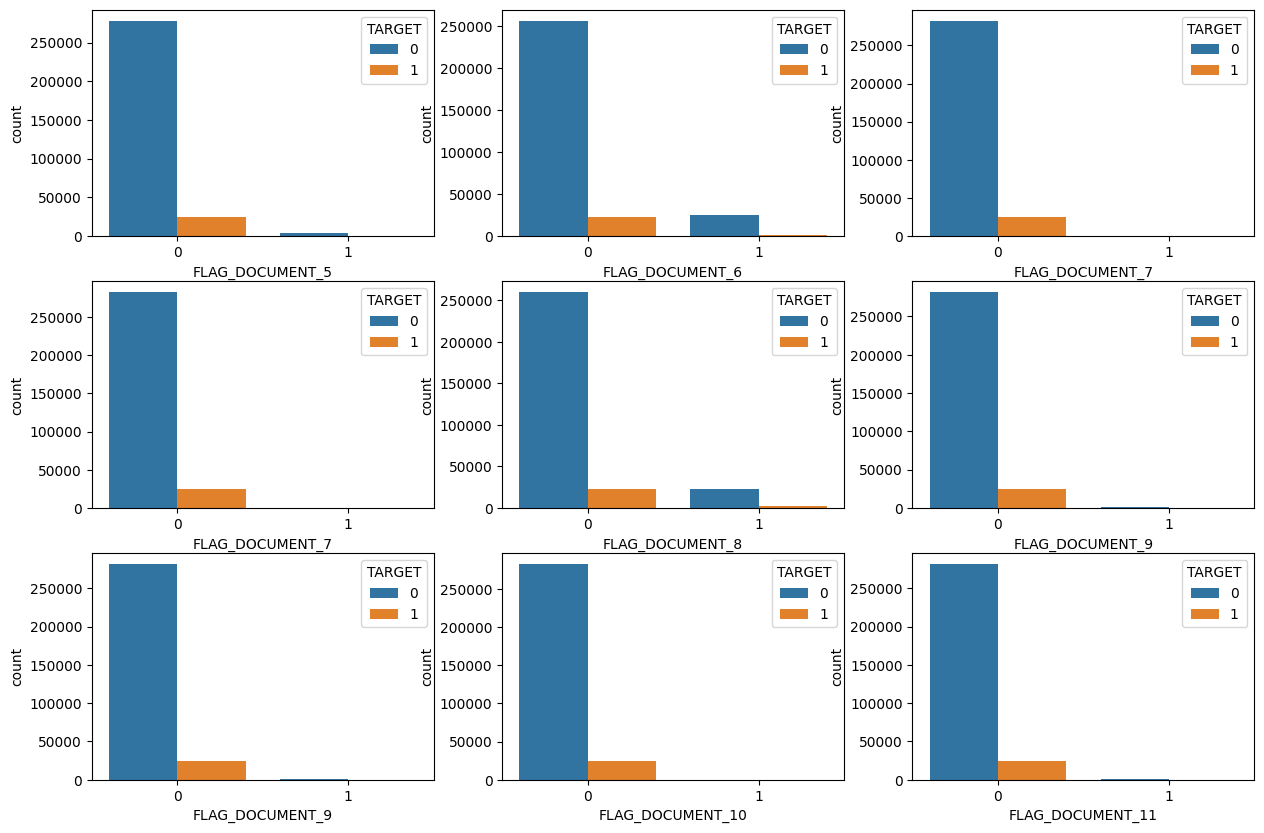

In [407]:
#Outlier in categoric-numeric #3
fig, ax = plt.subplots(3,3, figsize=(15,10))

for i in range(3):
  for j in range(3):
    sns.countplot(x=cat_in_num[2*i+j+18], data = df_train, hue = 'TARGET', ax=ax[i][j])

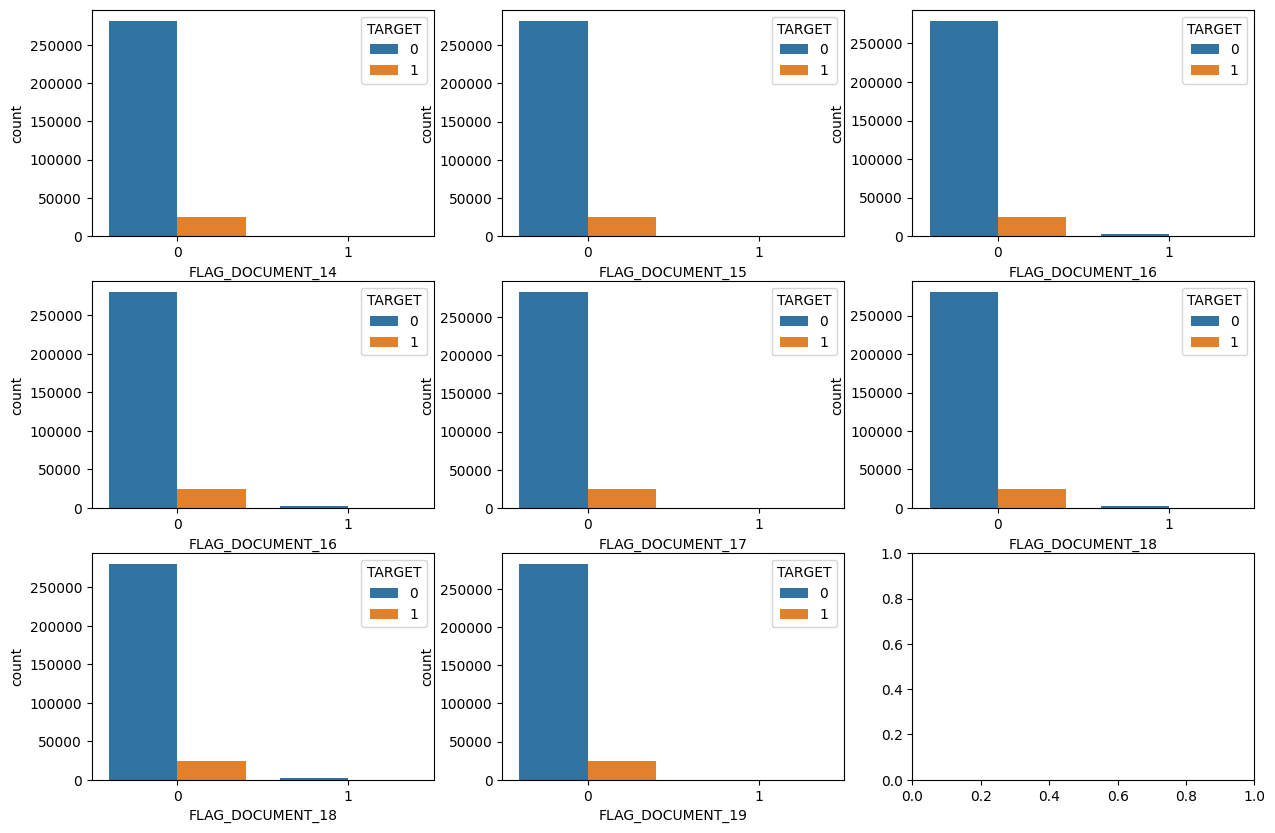

In [408]:
#Outlier in categoric-numeric #4
fig, ax = plt.subplots(3,3, figsize=(15,10))

for i in range(3):
  for j in range(3):
    if (i,j)==(2,2):
      break
    sns.countplot(x=cat_in_num[2*i+j+27], data = df_train, hue = 'TARGET', ax=ax[i][j])

#### Viz Categoric Data

In [409]:
print(cat)

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')


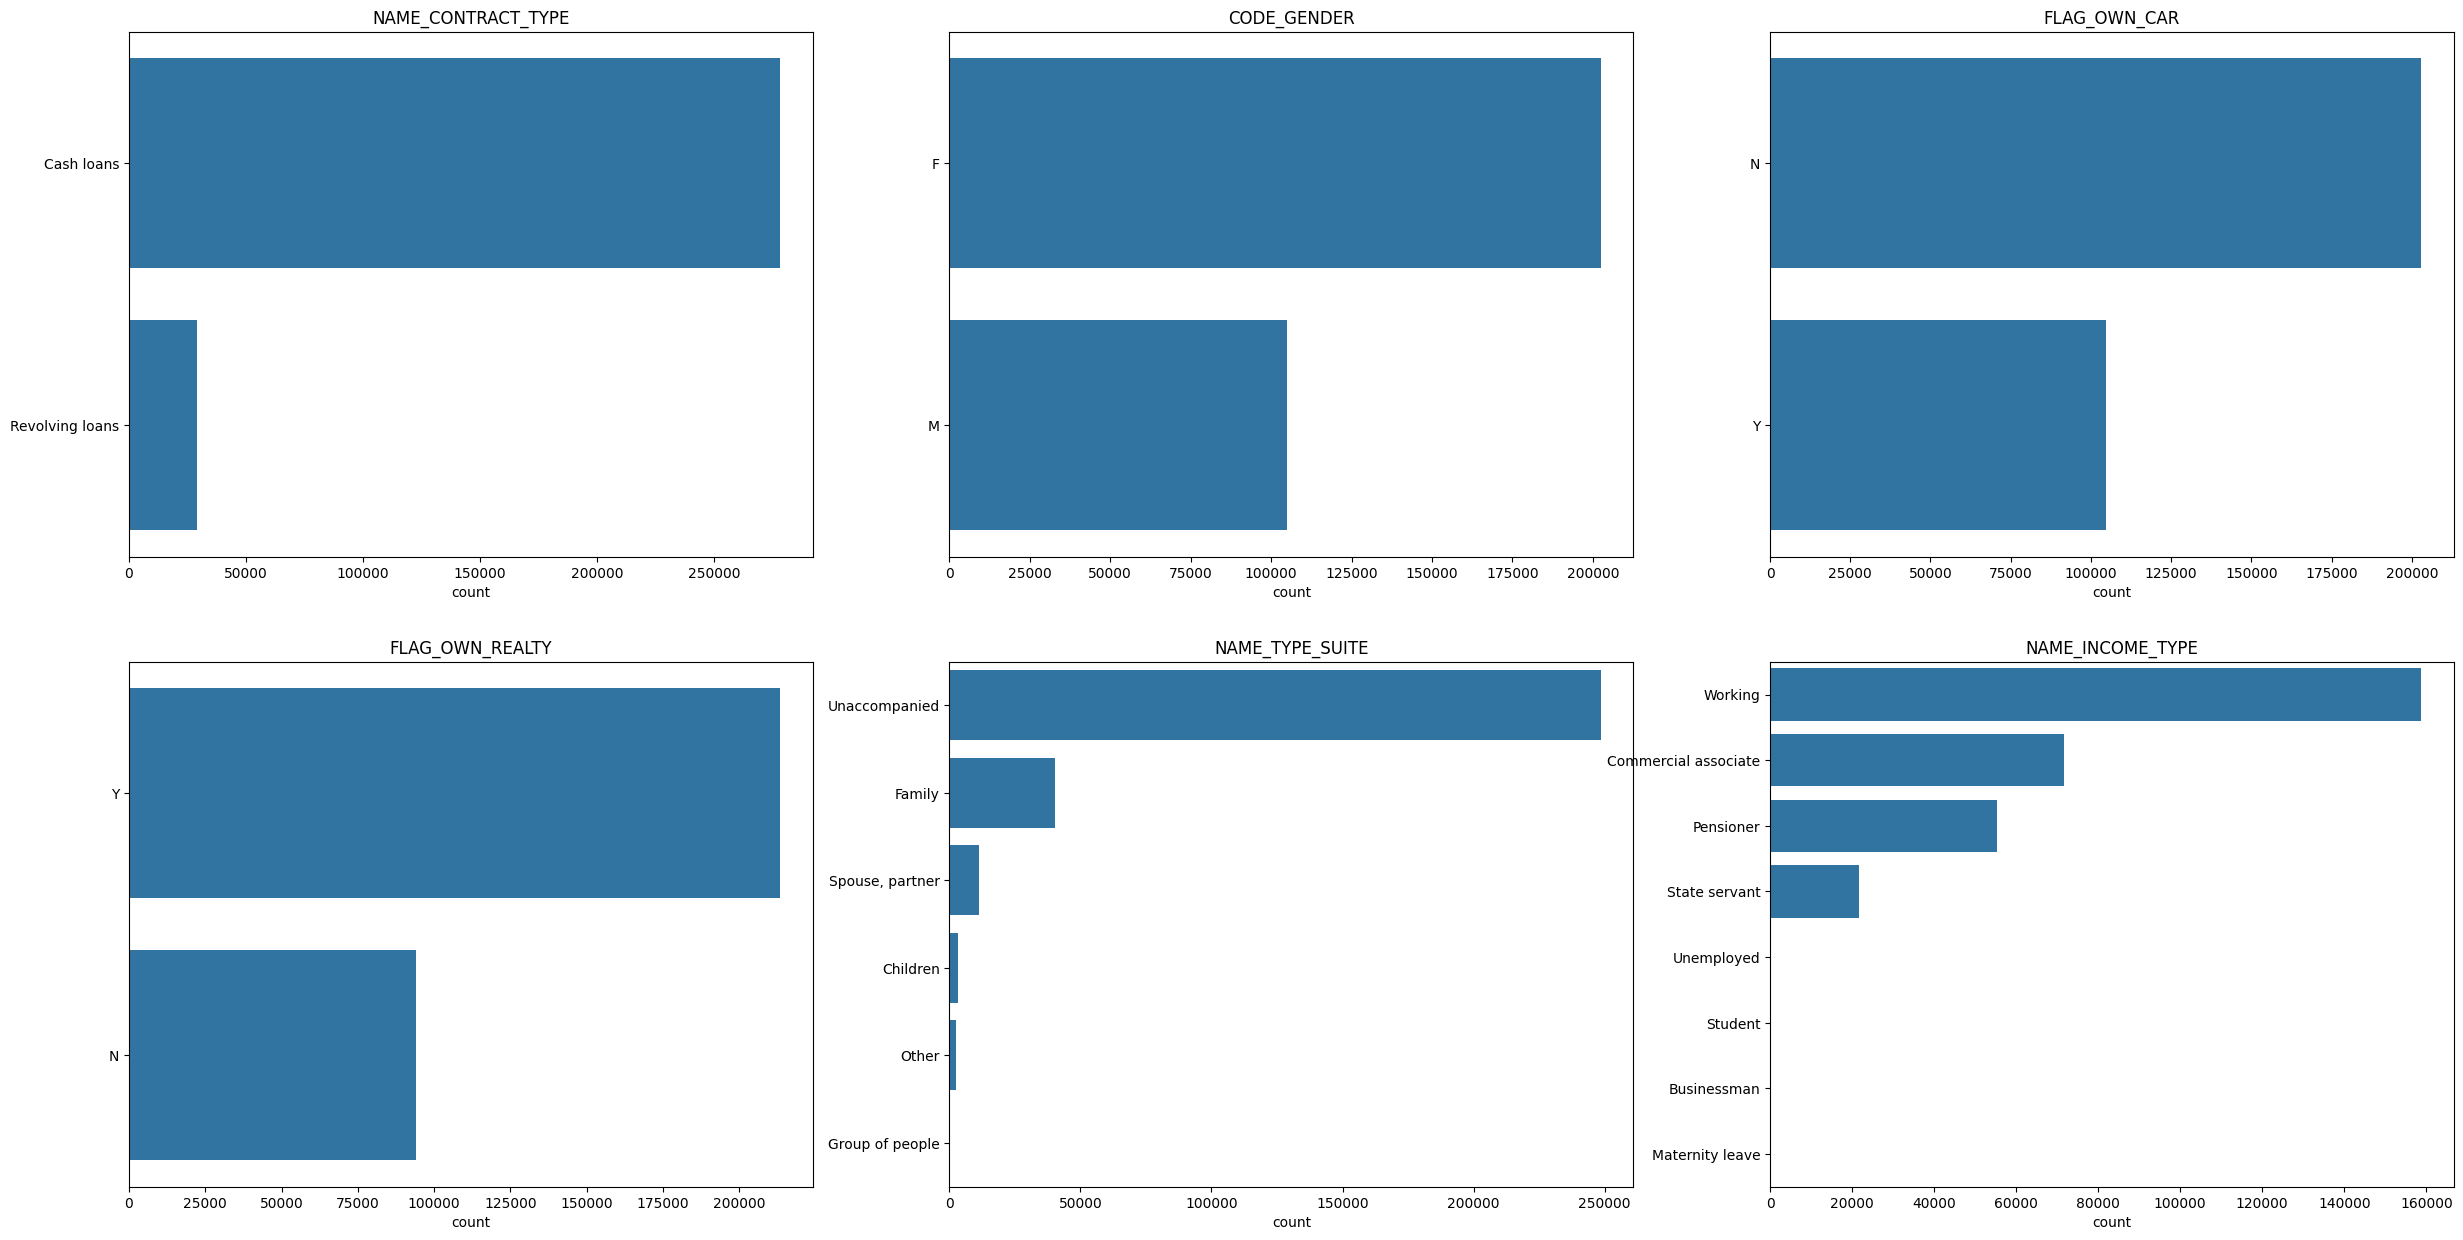

In [410]:
#Outlier in categoric#1
fig, ax = plt.subplots(2,3, figsize=(30,15))

for i in range(2):
  for j in range(3):
    sns.countplot(y=cat[3*i+j], data = df_train_v1, order=df_train_v1.groupby(cat[3*i+j]).size().sort_values(ascending=False).index, ax=ax[i][j])
    ax[i][j].set_ylabel('')
    ax[i][j].set_title(cat[3*i+j])

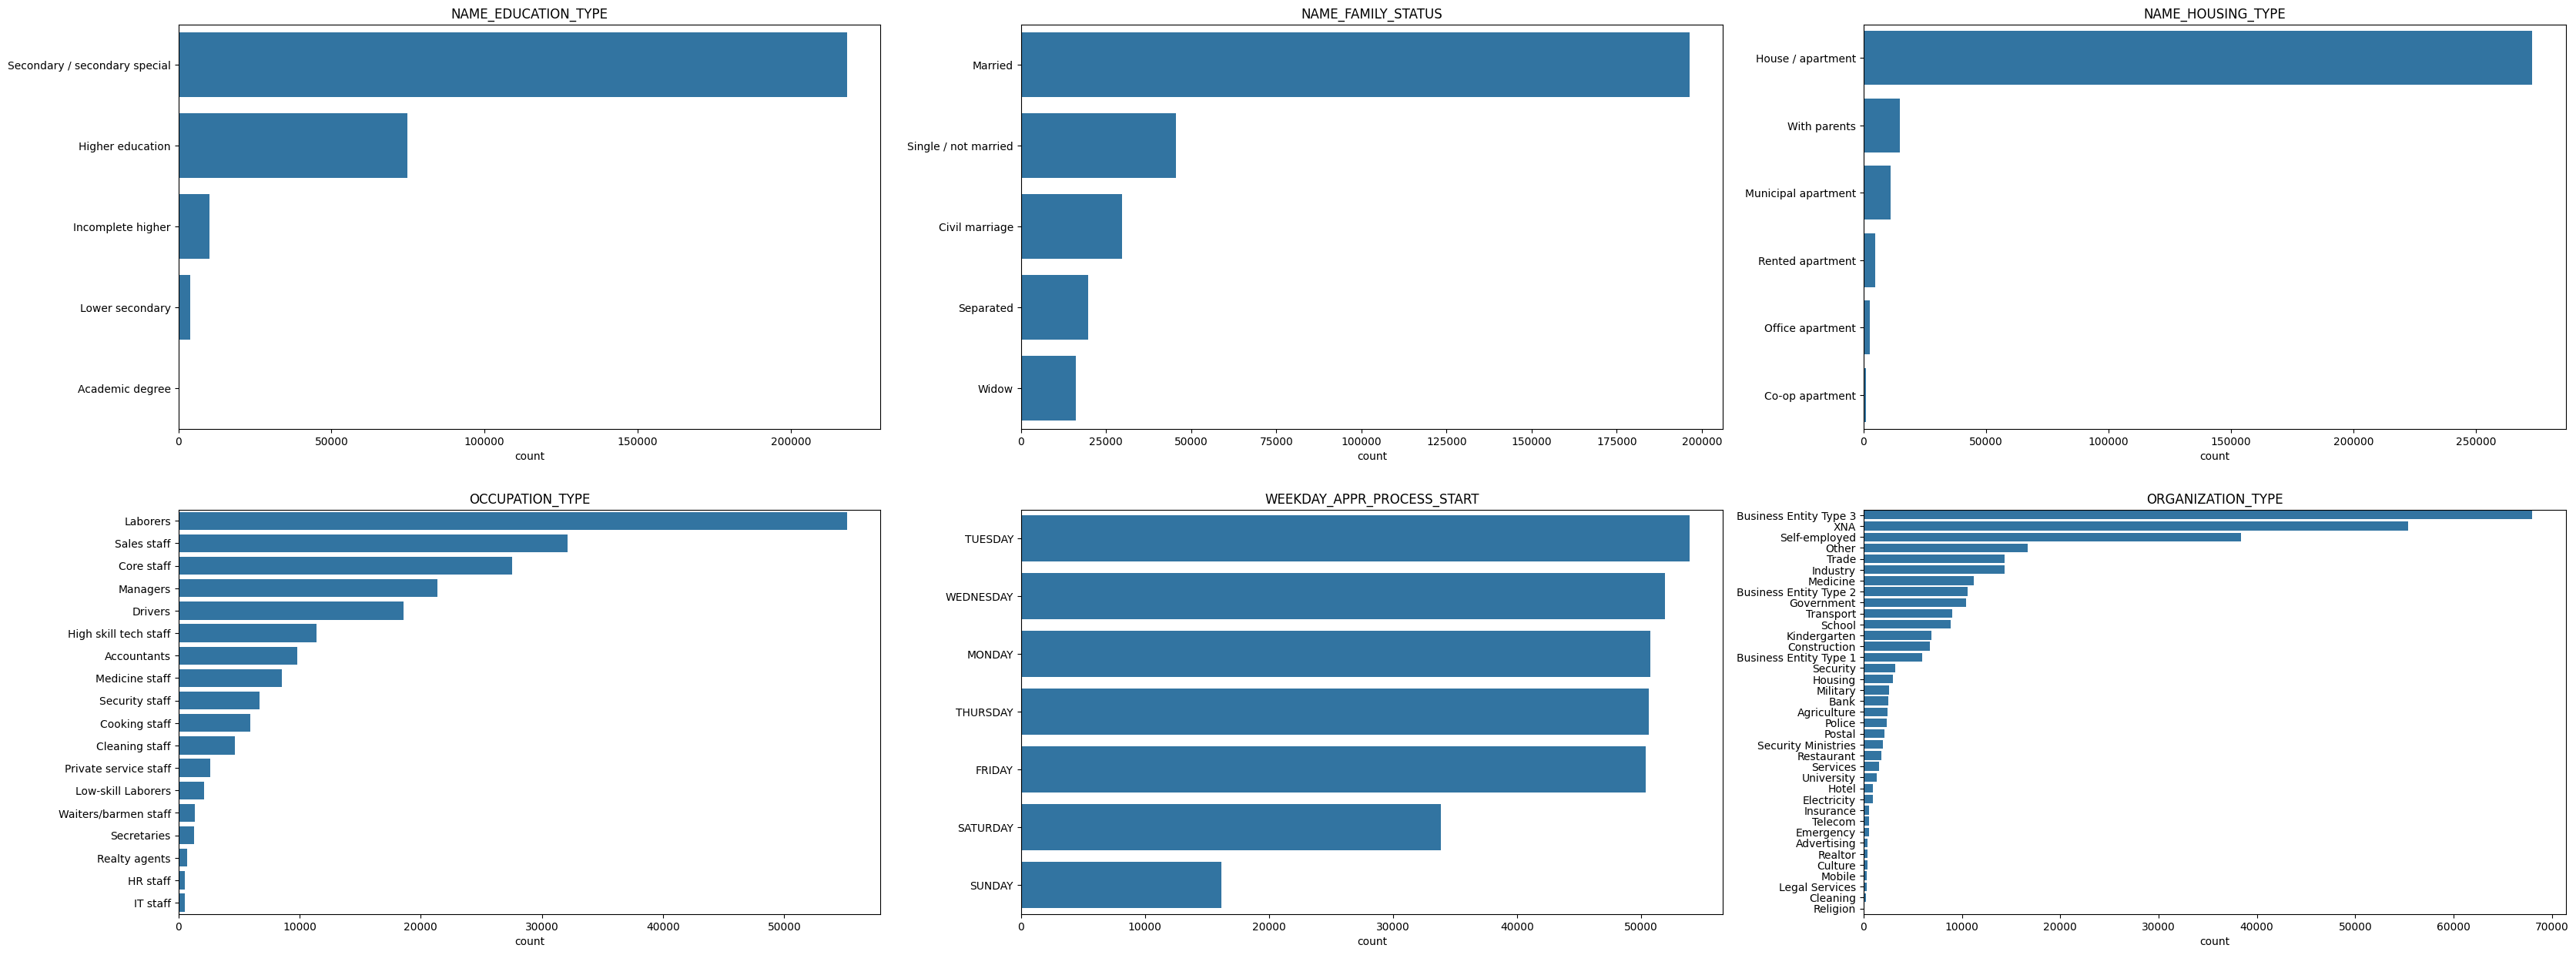

In [411]:
#Outlier in categoric#2
fig, ax = plt.subplots(2,3, figsize=(40,15))

for i in range(2):
  for j in range(3):
    sns.countplot(y=cat[3*i+j+6], data = df_train_v1,order=df_train_v1.groupby(cat[3*i+j+6]).size().sort_values(ascending=False).index, ax=ax[i][j])
    ax[i][j].set_ylabel('')
    ax[i][j].set_title(cat[3*i+j+6])

In [412]:
df_train_v1['CODE_GENDER'].replace({'XNA':df_train_v1['CODE_GENDER'].mode()[0]},inplace=True)
df_train_v1['NAME_FAMILY_STATUS'].replace({'Unknown':np.nan},inplace=True)

df_train_v1['ORGANIZATION_TYPE']=df_train_org['ORGANIZATION_TYPE']
df_train_v1['ORGANIZATION_TYPE'].replace({'XNA':np.nan},inplace=True)

#### Numeric Data

In [413]:
print(num)

['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [414]:
df_train_v1[num].describe().loc[['min','mean','50%','std','max']]

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
min,0.000,25650.000,45000.000,1615.500,40500.000,0.000,20.520,0.000,0.000,0.000,1.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
mean,0.417,168797.919,599026.000,27108.574,538396.207,0.021,43.937,185.548,13.661,8.203,2.153,12.063,0.514,0.511,1.421,0.143,1.404,0.100,2.638,0.006,0.007,0.034,0.267,0.264,1.900
50%,0.000,147150.000,513531.000,24903.000,450000.000,0.019,43.150,6.080,12.340,8.920,2.000,12.000,0.566,0.535,0.000,0.000,0.000,0.000,2.070,0.000,0.000,0.000,0.000,0.000,1.000
std,0.722,237123.146,402490.777,14493.737,369446.461,0.014,11.956,382.039,9.652,4.135,0.910,3.266,0.191,0.195,2.316,0.442,2.296,0.359,2.265,0.084,0.111,0.205,0.916,0.611,1.869
max,19.000,117000000.000,4050000.000,258025.500,4050000.000,0.073,69.120,1000.670,67.590,19.720,16.000,23.000,0.855,0.896,30.000,7.000,30.000,6.000,11.760,4.000,9.000,8.000,27.000,8.000,25.000


In [415]:
df_train_v1['CNT_FAM_MEMBERS'].replace({20: np.nan}, inplace = True)
df_train_v1['OBS_30_CNT_SOCIAL_CIRCLE'].replace({348: np.nan}, inplace = True)
df_train_v1['OBS_60_CNT_SOCIAL_CIRCLE'].replace({344: np.nan}, inplace = True)
df_train_v1['DEF_30_CNT_SOCIAL_CIRCLE'].replace({34: np.nan}, inplace = True)
df_train_v1['AMT_REQ_CREDIT_BUREAU_QRT'].replace({261: np.nan}, inplace = True)

In [416]:
df_train_v1[num].describe().loc[['min','mean','50%','std','max']]

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
min,0.000,25650.000,45000.000,1615.500,40500.000,0.000,20.520,0.000,0.000,0.000,1.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
mean,0.417,168797.919,599026.000,27108.574,538396.207,0.021,43.937,185.548,13.661,8.203,2.153,12.063,0.514,0.511,1.421,0.143,1.404,0.100,2.638,0.006,0.007,0.034,0.267,0.264,1.900
50%,0.000,147150.000,513531.000,24903.000,450000.000,0.019,43.150,6.080,12.340,8.920,2.000,12.000,0.566,0.535,0.000,0.000,0.000,0.000,2.070,0.000,0.000,0.000,0.000,0.000,1.000
std,0.722,237123.146,402490.777,14493.737,369446.461,0.014,11.956,382.039,9.652,4.135,0.910,3.266,0.191,0.195,2.316,0.442,2.296,0.359,2.265,0.084,0.111,0.205,0.916,0.611,1.869
max,19.000,117000000.000,4050000.000,258025.500,4050000.000,0.073,69.120,1000.670,67.590,19.720,16.000,23.000,0.855,0.896,30.000,7.000,30.000,6.000,11.760,4.000,9.000,8.000,27.000,8.000,25.000


**Days Employed Anomaly**

In [417]:
df_train_v1['DAYS_EMPLOYED'].describe()

count   307511.000
mean       185.548
std        382.039
min          0.000
25%          2.560
50%          6.080
75%         15.640
max       1000.670
Name: DAYS_EMPLOYED, dtype: float64

In [418]:
df_train_v1.groupby(by='DAYS_EMPLOYED').size().reset_index(name='count').sort_values(by='count',ascending=False).head()

,DAYS_EMPLOYED,count
4055,1000.670,55374
55,0.550,547
59,0.590,518
61,0.610,512
53,0.530,508


In [419]:
max_dayemploy = df_train_v1['DAYS_EMPLOYED'].max()
anom = df_train_v1[df_train_v1['DAYS_EMPLOYED'] == max_dayemploy]
non_anom = df_train_v1[df_train_v1['DAYS_EMPLOYED'] != max_dayemploy]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Text(0.5, 0, 'Days Employment')

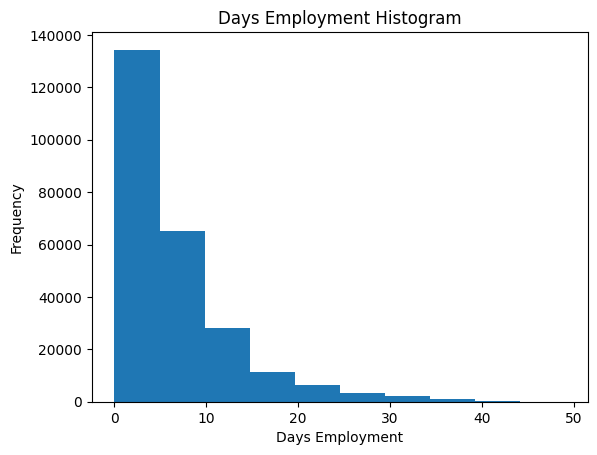

In [420]:
df_train_v1['DAYS_EMPLOYED'].replace({max_dayemploy: np.nan}, inplace = True)

df_train_v1['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

**AMT**

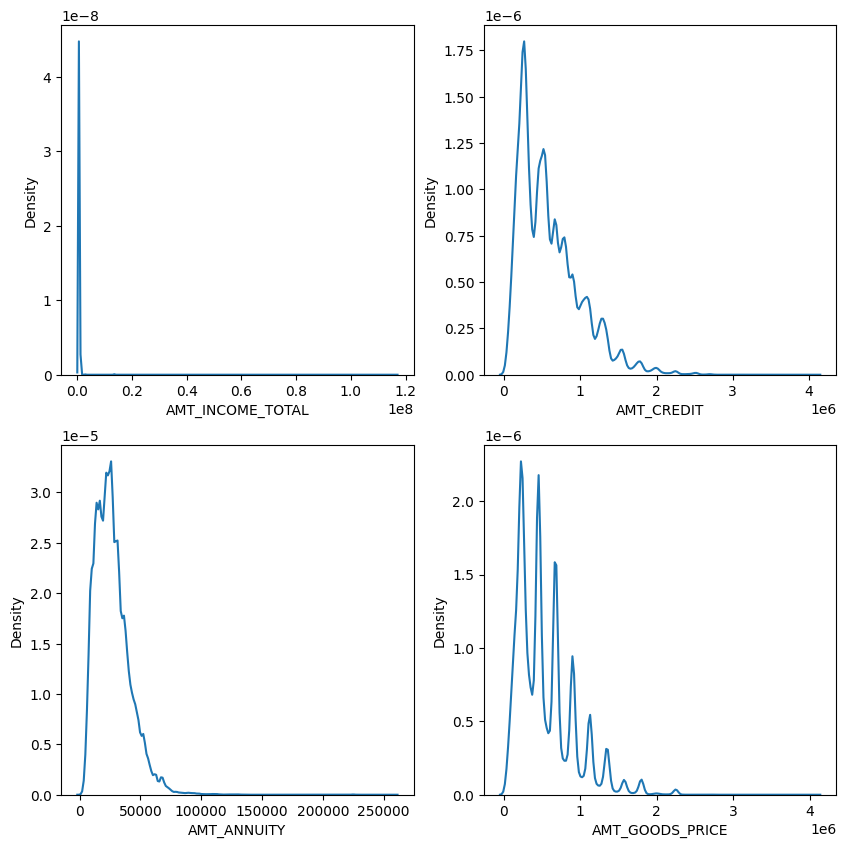

In [421]:
amt = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']
fig, ax = plt.subplots(2,2, figsize=(10,10))

for i in range(2):
  for j in range(2):
    sns.kdeplot(x=amt[2*i+j], data = df_train_v1,ax=ax[i][j])

In [422]:
for i in range(len(amt)):
  print(df_train_v1.groupby(amt[i]).size().reset_index(name='count').sort_values(by=amt[i],ascending=False).head())

      AMT_INCOME_TOTAL  count
2547     117000000.000      1
2546      18000090.000      1
2545      13500000.000      1
2544       9000000.000      1
2543       6750000.000      1
      AMT_CREDIT  count
5602 4050000.000      8
5601 4031032.500      1
5600 4027680.000      1
5599 3956274.000      1
5598 3860019.000      1
       AMT_ANNUITY  count
13671   258025.500      1
13670   230161.500      1
13669   225000.000     23
13668   220297.500      1
13667   216589.500      1
      AMT_GOODS_PRICE  count
1001      4050000.000      8
1000      3825000.000      1
999       3712500.000      1
998       3600000.000      3
997       3555000.000      1


<Axes: xlabel='AMT_INCOME_TOTAL', ylabel='Density'>

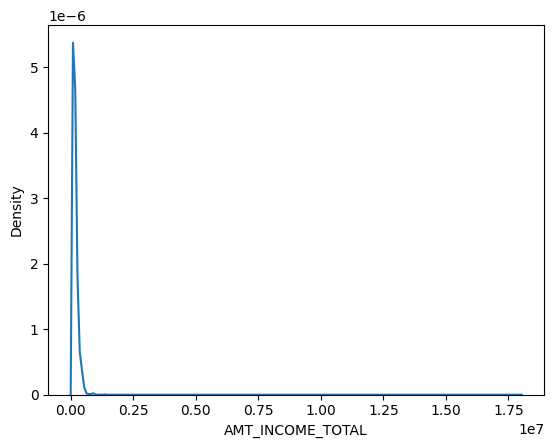

In [423]:
df_train_v1['AMT_INCOME_TOTAL'].replace({117000000: np.nan}, inplace = True)
sns.kdeplot(x='AMT_INCOME_TOTAL', data = df_train_v1)

### Handling Null Values

In [424]:
missing_values_table(df_train_v1).reset_index()

Your selected dataframe has 72 columns.
There are 22 columns that have missing values.


,index,Missing Values,% of Total Values
0,OCCUPATION_TYPE,96391,31.300
1,EXT_SOURCE_3,60965,19.800
2,DAYS_EMPLOYED,55374,18.000
3,ORGANIZATION_TYPE,55374,18.000
4,AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.500
5,AMT_REQ_CREDIT_BUREAU_QRT,41519,13.500
6,AMT_REQ_CREDIT_BUREAU_MON,41519,13.500
7,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.500
8,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.500
9,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.500


In [425]:
df_train_v1.isnull().sum(axis=1).value_counts().reset_index(name='count')

,index,count
0,0,167730
1,1,46838
2,3,43985
3,7,28137
4,10,7589
5,8,5658
6,4,4137
7,2,2915
8,5,239
9,11,138


In [426]:
num_col_null = df_train_v1.select_dtypes(include='number')
num_col_null = num_col_null.columns[num_col_null.isnull().any()]
num_col_null

Index(['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [427]:
cat_col_null = df_train_v1.select_dtypes(include='object')
cat_col_null = cat_col_null.columns[cat_col_null.isnull().any()]
cat_col_null

Index(['NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE'],
      dtype='object')

In [428]:
# Impute Left and Right Skewed in numeric columns
for i in range(len(num_col_null)):
  if df_train_v1[num_col_null[i]].mean()>df_train_v1[num_col_null[i]].median():
    df_train_v1[num_col_null[i]].fillna(df_train_v1[num_col_null[i]].mean(),inplace=True)
  else:
    df_train_v1[num_col_null[i]].fillna(df_train_v1[num_col_null[i]].median(),inplace=True)

# Impute categoric columns with mode
for i in range(len(cat_col_null)):
  df_train_v1[cat_col_null[i]].fillna(df_train_v1[cat_col_null[i]].mode()[0],inplace=True)

In [429]:
missing_values_table(df_train_v1).reset_index()

Your selected dataframe has 72 columns.
There are 0 columns that have missing values.


,index,Missing Values,% of Total Values


In [430]:
# Find correlations with the target and sort
correlations = df_train_v1.corr()['TARGET'].sort_values(ascending=False).reset_index()

# Display correlations
print('Most Positive Correlations:\n', correlations.head(10))
print('\nMost Negative Correlations:\n', correlations.tail(10))

Most Positive Correlations:
                          index  TARGET
0                       TARGET   1.000
1  REGION_RATING_CLIENT_W_CITY   0.061
2         REGION_RATING_CLIENT   0.059
3       REG_CITY_NOT_WORK_CITY   0.051
4               FLAG_EMP_PHONE   0.046
5       REG_CITY_NOT_LIVE_CITY   0.044
6              FLAG_DOCUMENT_3   0.044
7     DEF_30_CNT_SOCIAL_CIRCLE   0.033
8      LIVE_CITY_NOT_WORK_CITY   0.033
9     DEF_60_CNT_SOCIAL_CIRCLE   0.032

Most Negative Correlations:
                          index  TARGET
50                  AMT_CREDIT  -0.030
51  REGION_POPULATION_RELATIVE  -0.037
52             AMT_GOODS_PRICE  -0.040
53           DAYS_REGISTRATION  -0.042
54             DAYS_ID_PUBLISH  -0.051
55      DAYS_LAST_PHONE_CHANGE  -0.055
56               DAYS_EMPLOYED  -0.070
57                  DAYS_BIRTH  -0.078
58                EXT_SOURCE_3  -0.156
59                EXT_SOURCE_2  -0.160


## Machine Learning Model

### One-Hot & Label Encoding

In [435]:
df_train_v2 = df_train_v1.copy()

In [436]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0
label_encoded_col = []

for col in df_train_v2:
    if df_train_v2[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_train_v2[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_train_v2[col])
            # Transform both training and testing data
            df_train_v2[col] = le.transform(df_train_v2[col])
            # df1_test[col] = le.transform(df1_test[col])

            # Keep track of how many columns were label encoded
            label_encoded_col.append(col)
            le_count += 1

print('%d columns were label encoded.' % le_count)
print(label_encoded_col)

4 columns were label encoded.
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


In [437]:
print('Training Features shape before one-hot: ', df_train_v1.shape)

# one-hot encoding of categorical variables
df_train_v2 = pd.get_dummies(df_train_v2)
# df1_test = pd.get_dummies(df_test)

print('Training Features shape: ', df_train_v2.shape)
# print('Testing Features shape: ', df_test.shape)

Training Features shape before one-hot:  (307511, 72)
Training Features shape:  (307511, 155)


In [438]:
df_train_v2

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_University
0,1,0,1,0,1,0,202500.000,406597.5

In [439]:
# Find correlations with the target and sort
correlations = df_train_v2.corr()['TARGET'].sort_values(ascending=False).reset_index()

# Display correlations
print('Most Positive Correlations:\n', correlations.head(10))
print('\nMost Negative Correlations:\n', correlations.tail(10))

Most Positive Correlations:
                                                index  TARGET
0                                             TARGET   1.000
1                        REGION_RATING_CLIENT_W_CITY   0.061
2                               REGION_RATING_CLIENT   0.059
3                           NAME_INCOME_TYPE_Working   0.057
4                                        CODE_GENDER   0.055
5                             REG_CITY_NOT_WORK_CITY   0.051
6  NAME_EDUCATION_TYPE_Secondary / secondary special   0.050
7                                     FLAG_EMP_PHONE   0.046
8                             REG_CITY_NOT_LIVE_CITY   0.044
9                                    FLAG_DOCUMENT_3   0.044

Most Negative Correlations:
                                     index  TARGET
145                       AMT_GOODS_PRICE  -0.040
146                     DAYS_REGISTRATION  -0.042
147            NAME_INCOME_TYPE_Pensioner  -0.046
148                       DAYS_ID_PUBLISH  -0.051
149                D

### Split Train-Valid

In [440]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def MinMax(X):
  scaler = MinMaxScaler()
  scaler.fit(X)
  return scaler.transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(df_train_v2.drop(columns='TARGET').values, df_train_v2['TARGET'], test_size=0.1, random_state=42)

X_train_std = MinMax(X_train)
X_valid_std = MinMax(X_valid)

print('Train set shape:',X_train_std.shape)
print('Validation set shape:',X_valid_std.shape)
# X_test_std = MinMax(df_ML_test.values)

Train set shape: (276759, 154)
Validation set shape: (30752, 154)


### Logreg Sci-kit

In [501]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score, precision_score,roc_auc_score, roc_curve, f1_score, confusion_matrix

lr_model = LogisticRegression()
lr_model.fit(X_train_std, y_train)
y_pred = lr_model.predict(X_valid_std)
print(accuracy_score(y_valid,y_pred))
print(recall_score(y_valid,y_pred))
print(precision_score(y_valid,y_pred))

0.918054110301769
0.009527590313616514
0.4897959183673469


In [512]:
y_valid

245895    0
98194     0
36463     0
249923    0
158389    0
         ..
263379    0
85196     0
218500    0
297062    0
147851    0
Name: TARGET, Length: 30752, dtype: int64

In [511]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

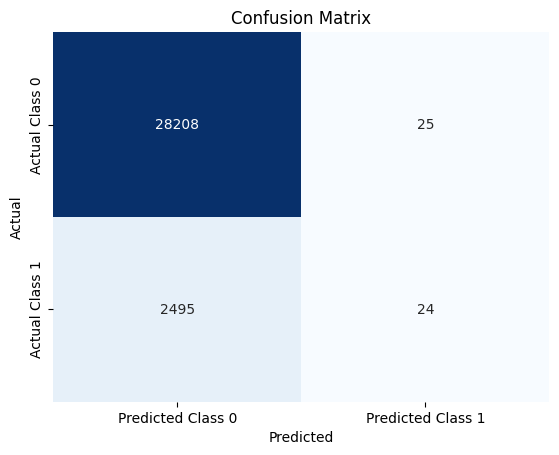

In [489]:
cm = confusion_matrix(y_valid.values, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Class 0', 'Predicted Class 1'],
            yticklabels=['Actual Class 0', 'Actual Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Multi Model

In [ ]:
from datetime import datetime as dt
from collections import defaultdict
from xgboost import XGBClassifier
import lightgbm as lgb
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, recall_score, precision_score,roc_auc_score, roc_curve, f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


In [ ]:
def modelling(x_train,x_test,y_train,y_test):
  result = defaultdict(list)

  lr = LogisticRegression()
  dt = DecisionTreeClassifier()
  ab = AdaBoostClassifier()
  nb = GaussianNB()
  knn = KNeighborsClassifier()
  xgb = XGBClassifier()
  rf = RandomForestClassifier()
  grad = GradientBoostingClassifier()
  LGBM = lgb.LGBMClassifier()


  list_model = [##('Logistic Regression',lr),
                ('Decision Tree',dt),
                ('AdaBoost', ab),
                ('Gaussian NB', nb),
                ###('K-Nearest Neighbor',knn),
                ('XgBoost', xgb),
                ##('Random Forest',rf),
                #('Gradient Boosting',grad),
                #('LightGBM',LGBM)
                ]

  for model_name, model in list_model:
      model.fit(X_train_std,y_train)
      #y_pred_proba = model.predict_proba(x_test)

      y_pred = model.predict(X_valid_std)

      accuracy = accuracy_score(y_valid,y_pred)
      recall = recall_score(y_valid,y_pred)
      precision = precision_score(y_valid,y_pred)
      #AUC = roc_auc_score(y_test, y_pred_proba[:, 1])

      result['model_name'].append(model_name)
      result['model'].append(model)
      result['accuracy'].append(accuracy)
      result['recall'].append(recall)
      result['precision'].append(precision)
      #result['AUC'].append(AUC)

      print(model_name,accuracy,recall,precision)
  return result

evaluation_summary = modelling(X_train, X_valid, y_train,y_valid)
evaluation_summary = pd.DataFrame(evaluation_summary)
evaluation_summary

### TF Logreg

In [496]:
import tensorflow as tf
import keras
from keras.models import Sequential

model = Sequential([
    tf.keras.layers.Dense(16,'relu',input_shape=(X_train_std.shape[1],)),
    tf.keras.layers.Dense(32,'relu'),
    tf.keras.layers.Dense(1,'sigmoid')

])

In [513]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics='accuracy')

history = model.fit(X_train_std,y_train,
                    validation_data=(X_valid_std,y_valid),
                    epochs=3)

Epoch 1/3
8649/8649 [==============================] - 42s 5ms/step - loss: 0.2519 - accuracy: 0.9194 - val_loss: 0.2539 - val_accuracy: 0.9181
Epoch 2/3
8649/8649 [==============================] - 35s 4ms/step - loss: 0.2517 - accuracy: 0.9194 - val_loss: 0.2539 - val_accuracy: 0.9181
Epoch 3/3
8649/8649 [==============================] - 32s 4ms/step - loss: 0.2516 - accuracy: 0.9194 - val_loss: 0.2539 - val_accuracy: 0.9181


In [514]:
y_pred = model.predict(X_valid_std)
y_pred

961/961 [==============================] - 2s 2ms/step


array([[0.25971594],
       [0.03313616],
       [0.15196076],
       ...,
       [0.01658959],
       [0.05199899],
       [0.10177524]], dtype=float32)

In [525]:
np.round(y_pred).sum()

0.0

In [524]:
y_valid.values.sum()

2519

In [ ]:
print('Accuracy:', accuracy_score(y_valid,y_pred))
print('Recall:', recall_score(y_valid,y_pred.values))
print('Precision:', precision_score(y_valid,y_pred.values))

In [ ]:
f1_score(y_valid, y_pred)

## Predict

In [ ]:
df_train = pd.read_csv('data/application_test.csv')
print('data shape:',df_train.shape)
df_train.head()